# COGS 109: Clustering of Wholesale Customers

## Source and Brief Description

Source: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers#

Each row in the dataset refers to a business that is the client of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories. The Channel column has 2 unique values for the type of businesses: horeca (Hotel/Restaurant/Cafa) and retailers. 


## Importing Important Modules:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import plotly.express as explot
import itertools
import warnings

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn import metrics
from sklearn.metrics import silhouette_score
from scipy.stats import boxcox, probplot, norm, shapiro

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")

## Importing the CSV Data and Gathering Information:


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/COGS109/Wholesale_customers_data.csv')

In [ ]:
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [ ]:
# store Channel column. Could be used as labels for the dataset?
Channel = data['Channel']
Region = data['Region']

# Change this if planning to use these 2 columns
data.drop(['Region', 'Channel'], axis = 1, inplace = True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Fresh             440 non-null    int64
 1   Milk              440 non-null    int64
 2   Grocery           440 non-null    int64
 3   Frozen            440 non-null    int64
 4   Detergents_Paper  440 non-null    int64
 5   Delicassen        440 non-null    int64
dtypes: int64(6)
memory usage: 20.8 KB


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


## Visualization and Analyses:

### Utilizing seaborn.barplot as visualizatoin package

Show point estimates and confidence intervals as rectangular bars.

A bar plot represents an estimate of central tendency for a numeric variable with the height of each rectangle and provides some indication of the uncertainty around that estimate using error bars.

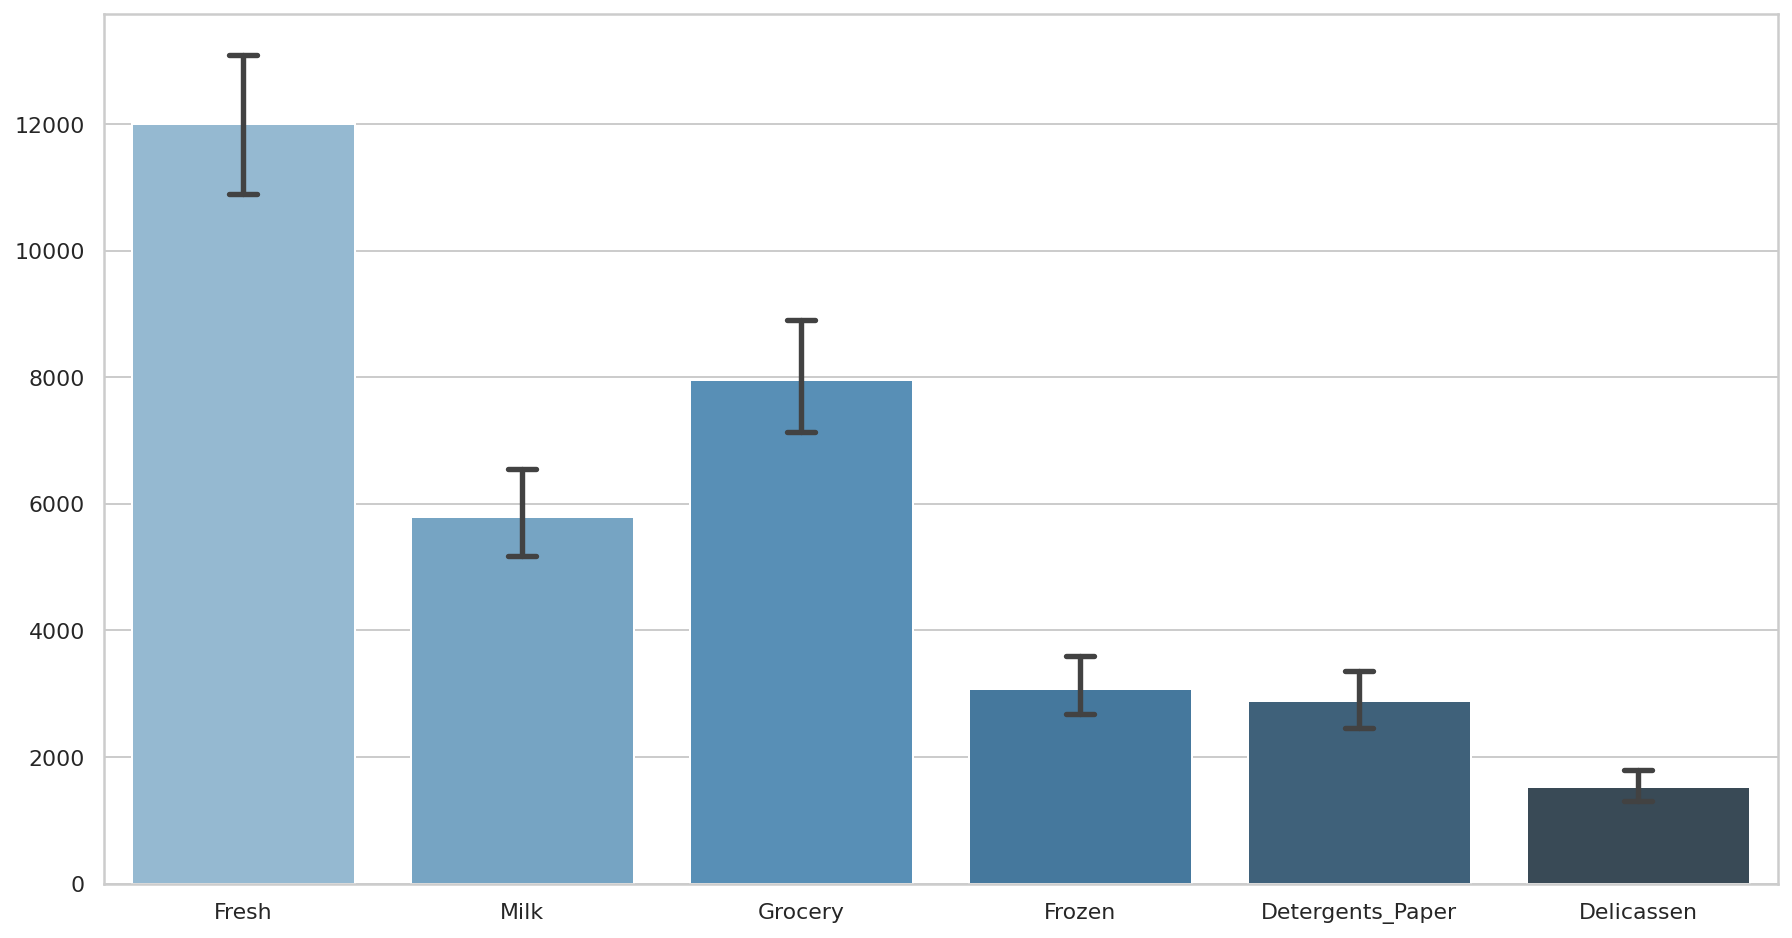

In [ ]:
plt.figure(figsize = (15,8))
sns.set_theme(style="whitegrid")
sns.barplot(data=data, capsize=.1, palette="Blues_d")
plt.show()

## Analyzation:

As percieved through the Seaborn Barplot, the first nominal category of Fresh has an approximate value of 12000, which exceeds the next highest category of Grocery by a staggering 4000. The confidence interval for Fresh extends from 11000 to 13000, giving an estimate of the true value of the Fresh category. Grocery has the next preceeding value of 8000, with confidence interval of approximately 7000 to 9000. This cateogry is the next popular nominal category in the business. Next, the milk category has a confidence interval of around 7000 to 5000, with an estimate count of 5900, which corresponds to a gross business client. Both Frozen and Detergents_Paper have the same count of around 3000, with the interval ranging from higher 3000s, approximately 3700, to lower quartile 3000s, around 3200. Lastly, the least popular business model is the Delicassen nominal group. This categorical group has less that 2000 in count, around 1750 with a confidence interval of around 1600 to 1900.

In [ ]:
# un-comment to plot pairs

# _ = sns.pairplot(data, diag_kind = 'kde', height=2, aspect=0.9)

Data is not normall distributed. We can try different transformations to find one that suits this dataset.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html#scipy.stats.probplot

https://stackoverflow.com/questions/48108582/how-to-interpret-scipy-stats-probplot-results

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html


## Data Transformation for Data Normalization

Since the data spans a space that is not normalized, we attempt to draw out a noramalized space. This preprocessing of the data allows for unskewed data that has a reduced span. 

## Visualization of the Regular Data

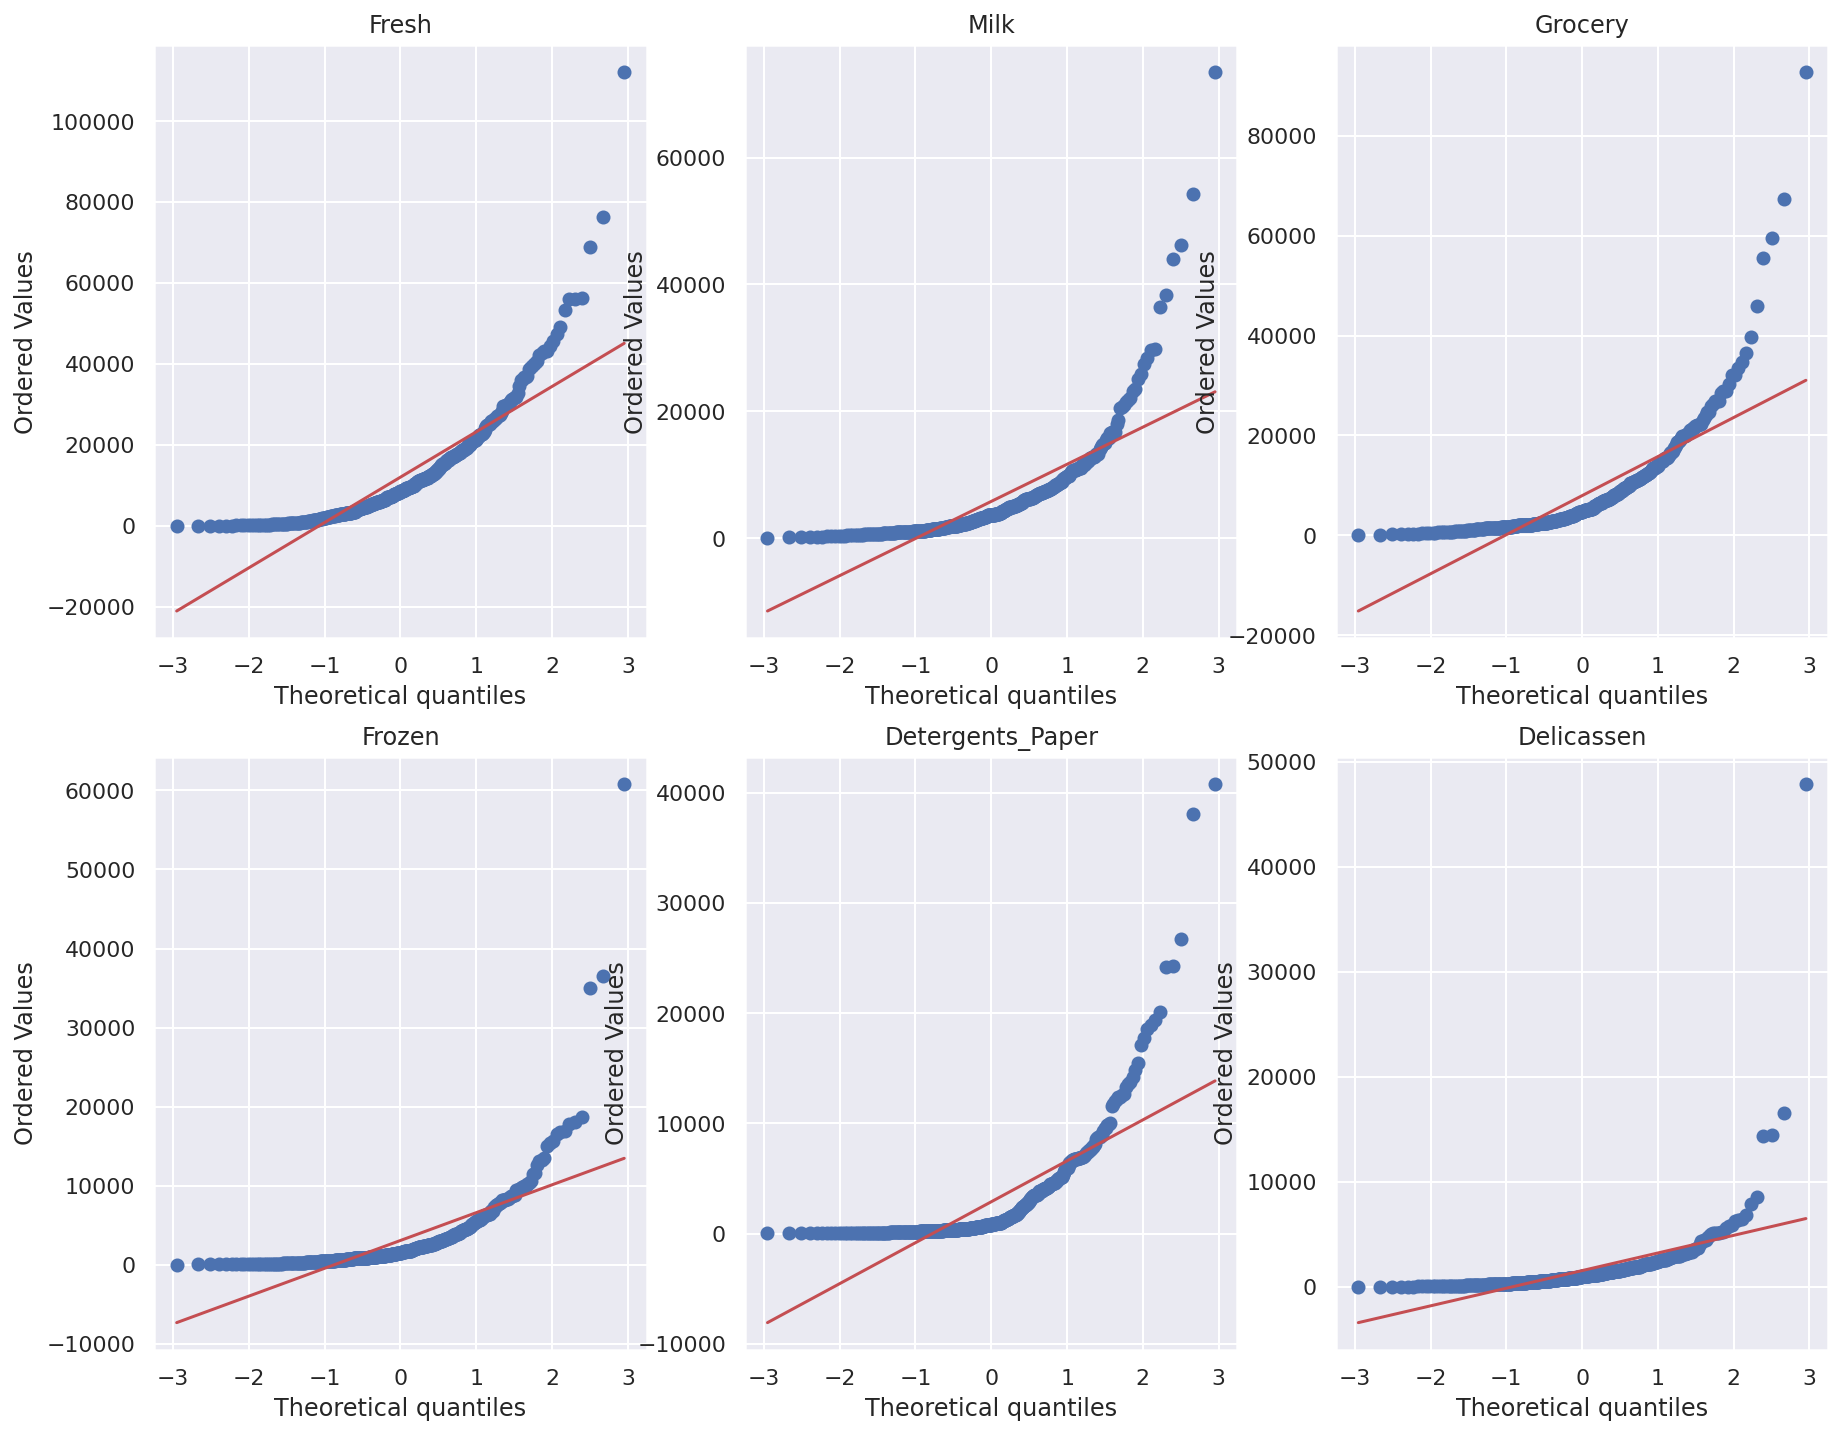

,Tests,p-value
Fresh,0.781436,7.918286e-24
Milk,0.628334,9.762062e-30
Grocery,0.676231,3.906209e-28
Frozen,0.528297,1.291332e-32
Detergents_Paper,0.605482,1.914593e-30
Delicassen,0.361068,1.753408e-36


In [ ]:
# testing on regular data

test = {}
plt.figure(figsize=(15, 12))

for i in range(0,6):
    ax = plt.subplot(2, 3, i+1)
    probplot(x=data[data.columns[i]], dist=norm, plot=ax)
    plt.title(data.columns[i])
    test[data.columns[i]] = shapiro(data[data.columns[i]])
    
plt.show()

pd.DataFrame(test, index=['Tests', 'p-value']).T

The graphs above visualize the regular data, which helps us witness the disparity the originates from the regular data.

## Visualization of the Log Transformed Data

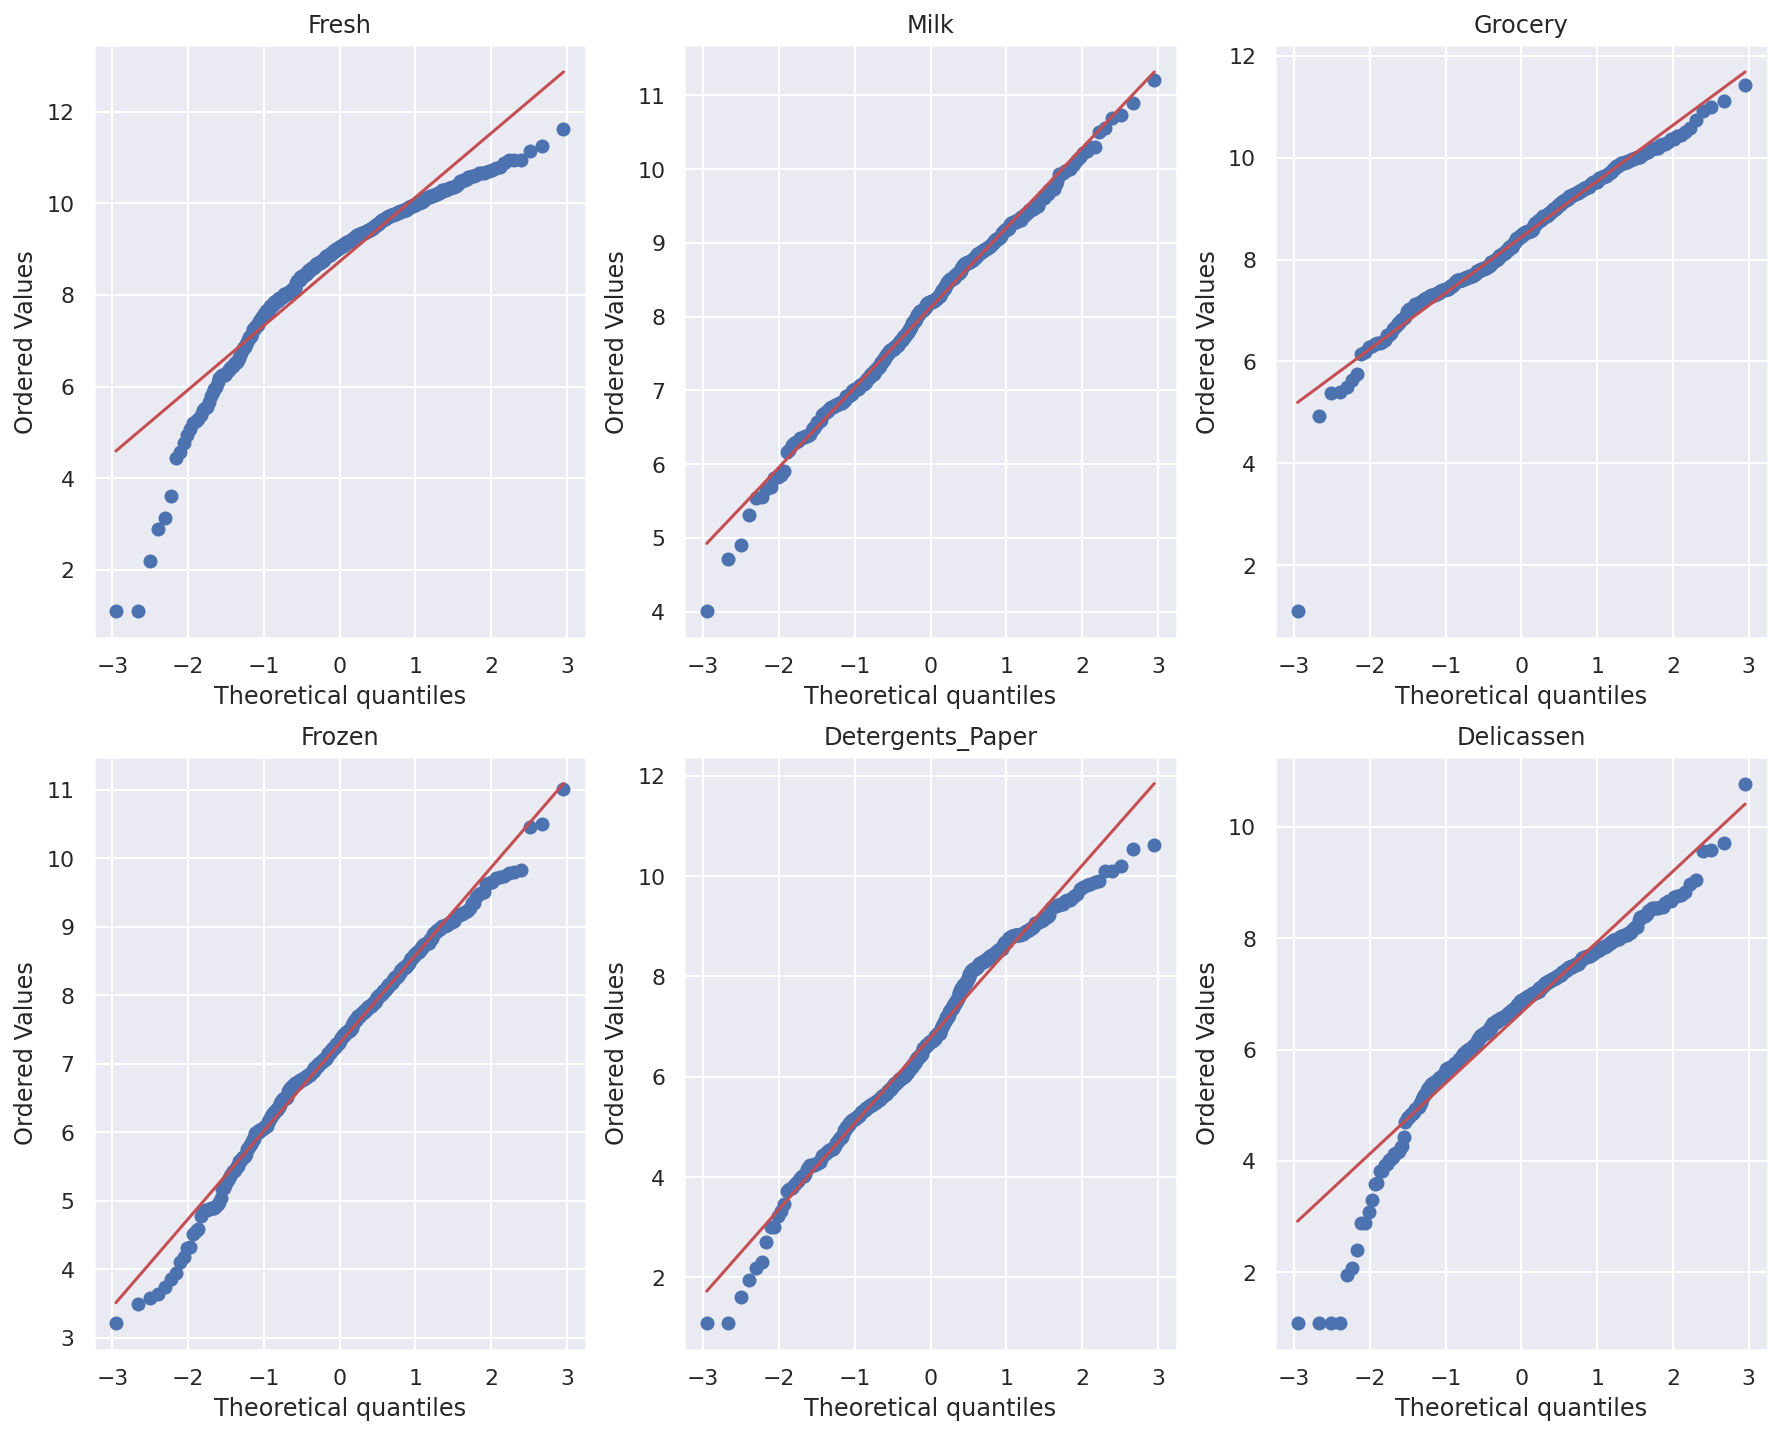

,Tests,p-value
Fresh,0.890065,3.303679e-17
Milk,0.994083,8.528145e-02
Grocery,0.964565,8.116720e-09
Frozen,0.990030,4.431482e-03
Detergents_Paper,0.981625,2.265693e-05
Delicassen,0.929627,1.575756e-13


In [ ]:
# testing on log transformed data
log_data = np.log(data)

test = {}
plt.figure(figsize=(15, 12))

for i in range(0,6):
    ax = plt.subplot(2, 3, i+1)
    probplot(x=log_data[log_data.columns[i]], dist=norm, plot=ax)
    plt.title(log_data.columns[i])
    test[log_data.columns[i]] = shapiro(log_data[log_data.columns[i]])
    
plt.show()

pd.DataFrame(test, index=['Tests', 'p-value']).T

The graphs above visualize the log-transformed data, which helps us perceive the new trend of the data and if it fits a normal distribution.

## BoxCox Transformation on Regular Data

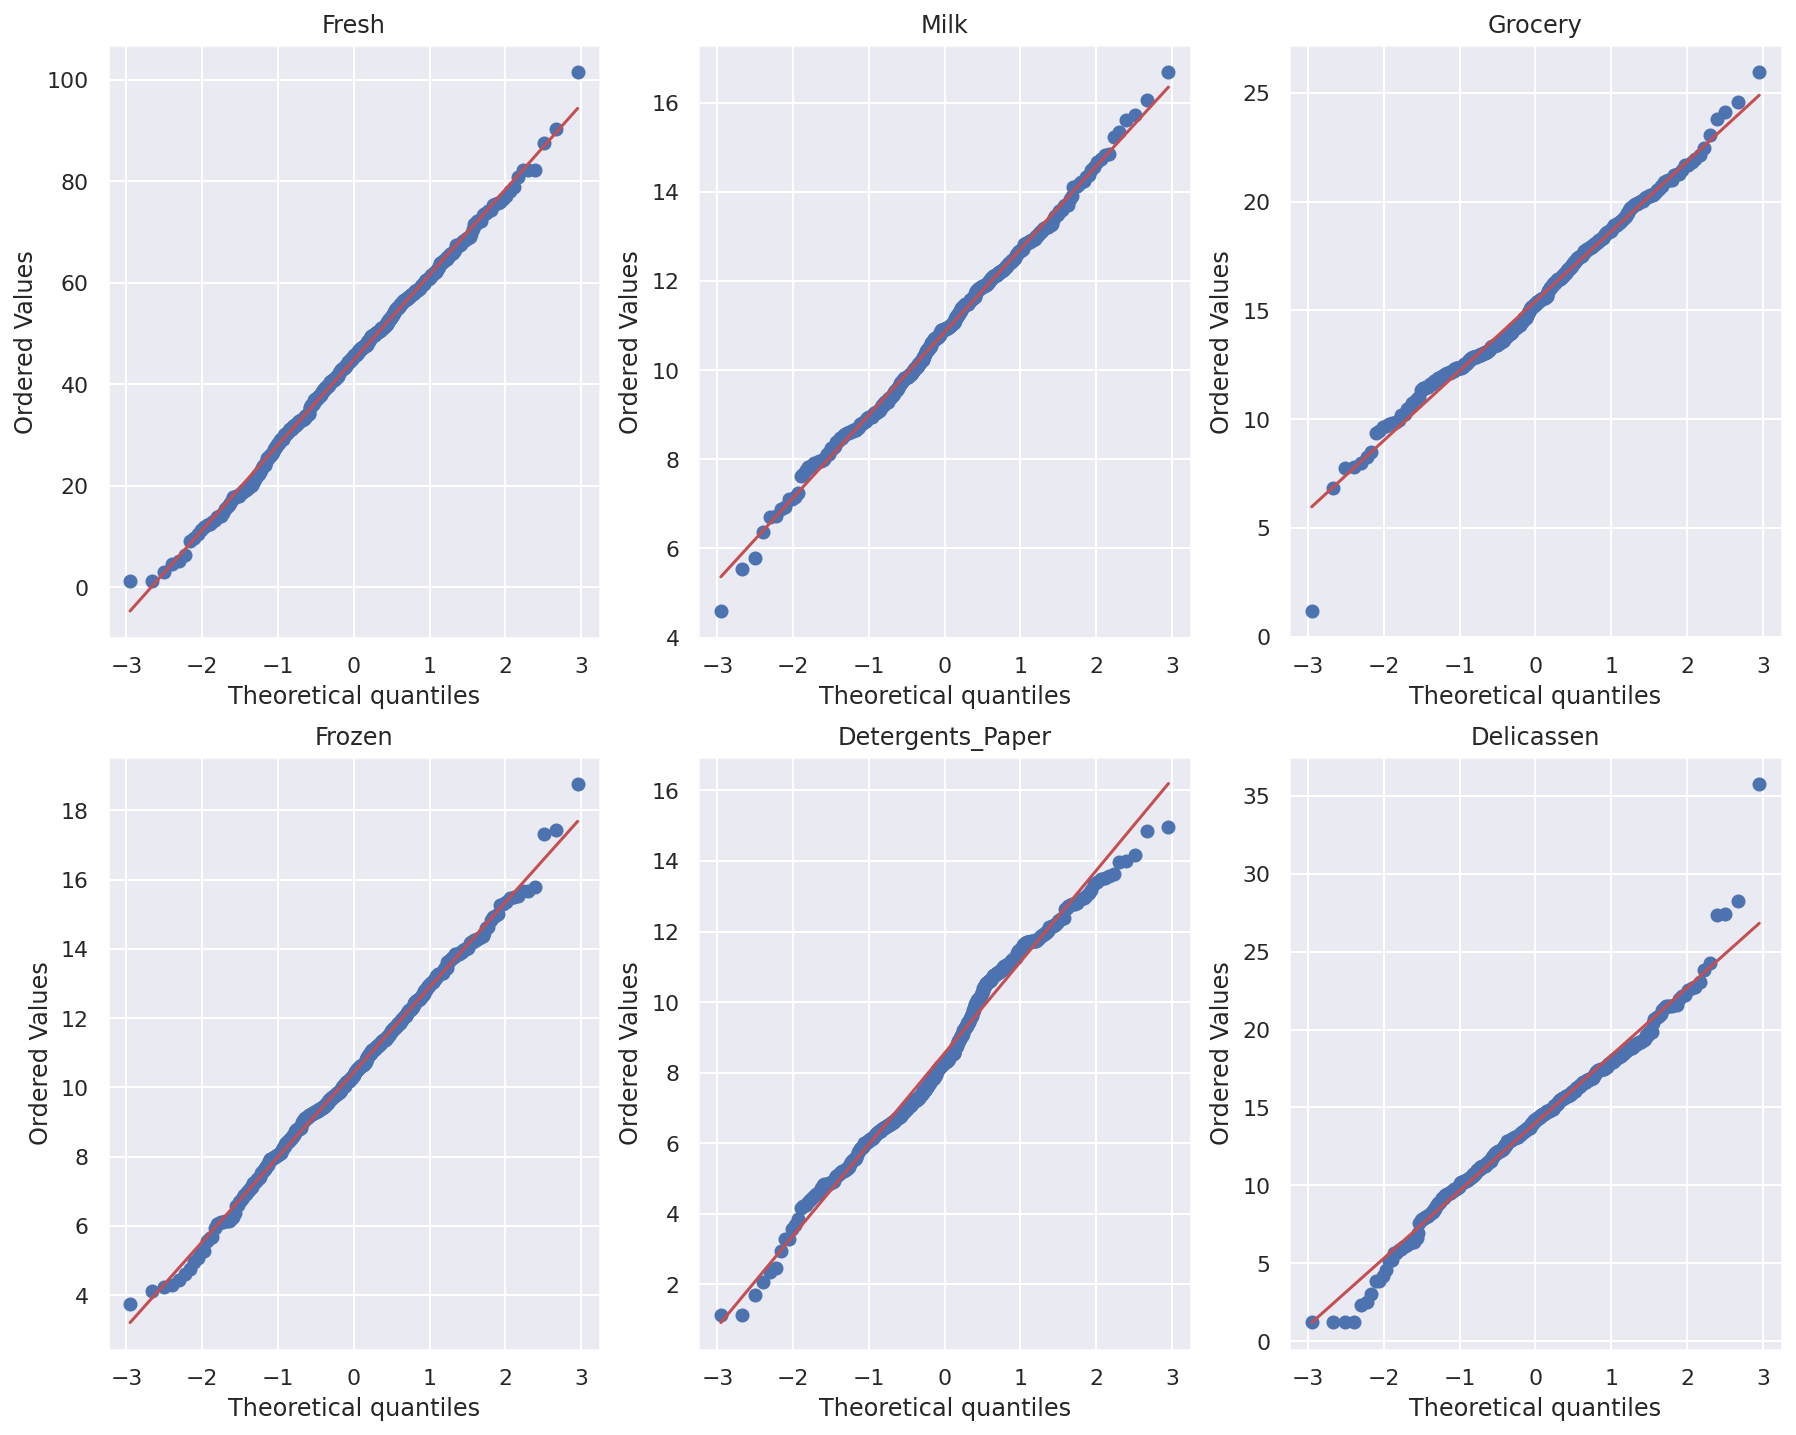

,Test,p-value
Fresh,0.997445,0.737682
Milk,0.996949,0.584299
Grocery,0.989161,0.002424
Frozen,0.997237,0.673424
Detergents_Paper,0.985208,0.000185
Delicassen,0.981869,0.000026


In [ ]:
test = dict()

plt.figure(figsize=(15, 12))
plt.title('BoxCox Transformation')

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    
    # testing with boxcox transformations
    x, _ = boxcox(data[data.columns[i]])
    probplot(x = x, dist=norm, plot=ax)
    plt.title(data.columns[i])
    test[data.columns[i]] = shapiro(x)
    
plt.show()

pd.DataFrame(test, index=['Test', 'p-value']).T

The graphs above visualize the BoxCox-transformed data. In these graphs, we see a better trend towards normalization than the last methods.

## StandardizeScaler implementation on Regular Data

Standardize features by removing the mean and scaling to unit variance:

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [ ]:
# use box-cox as the transformation of choice and apply StandardScaler

box = PowerTransformer(method='box-cox')
box_data = box.fit_transform(data)
stnrd_data = StandardScaler().fit_transform(box_data)

data_normal = pd.DataFrame(stnrd_data, columns=data.columns)
print("Standard Scaled Data:")
data_normal.head()


Standard Scaled Data:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.412646,0.979303,0.392937,-1.456705,0.617238,0.335779
1,-0.111180,0.995096,0.626729,0.079718,0.748629,0.599877
2,-0.196043,0.887891,0.408738,0.331996,0.790324,2.245295
3,0.457763,-0.965094,-0.156523,1.173643,-0.373844,0.606332
4,1.028704,0.412455,0.344961,0.741520,0.364211,1.738881


In [ ]:
# un-comment to plot pairs

# _ = sns.pairplot(data_normal, diag_kind = 'kde', height=2, aspect=0.9)

In [ ]:
corr = data_normal.corr()
corr

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,1.000000,-0.023114,-0.106490,0.409108,-0.180152,0.274444
Milk,-0.023114,1.000000,0.777832,-0.044705,0.684856,0.384415
Grocery,-0.106490,0.777832,1.000000,-0.161393,0.818136,0.283831
Frozen,0.409108,-0.044705,-0.161393,1.000000,-0.219160,0.277641
Detergents_Paper,-0.180152,0.684856,0.818136,-0.219160,1.000000,0.178416
Delicassen,0.274444,0.384415,0.283831,0.277641,0.178416,1.000000


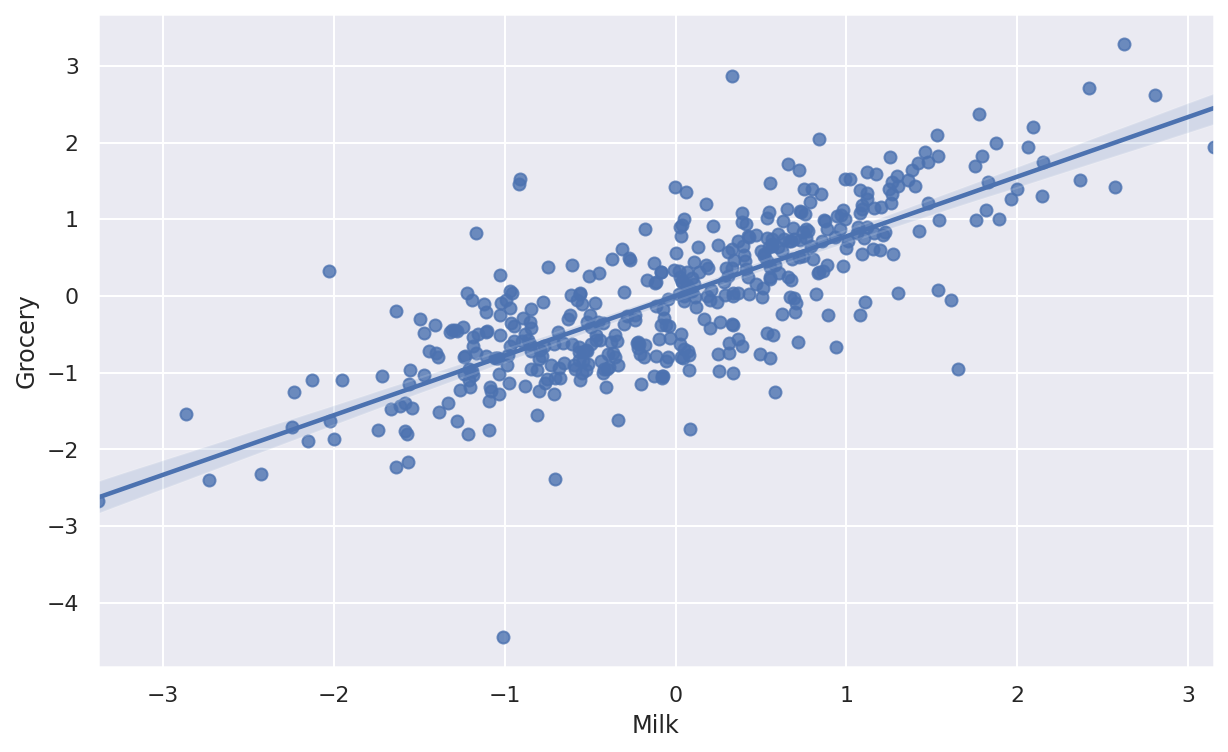

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(data=data_normal, x="Milk",y="Grocery")
plt.show()

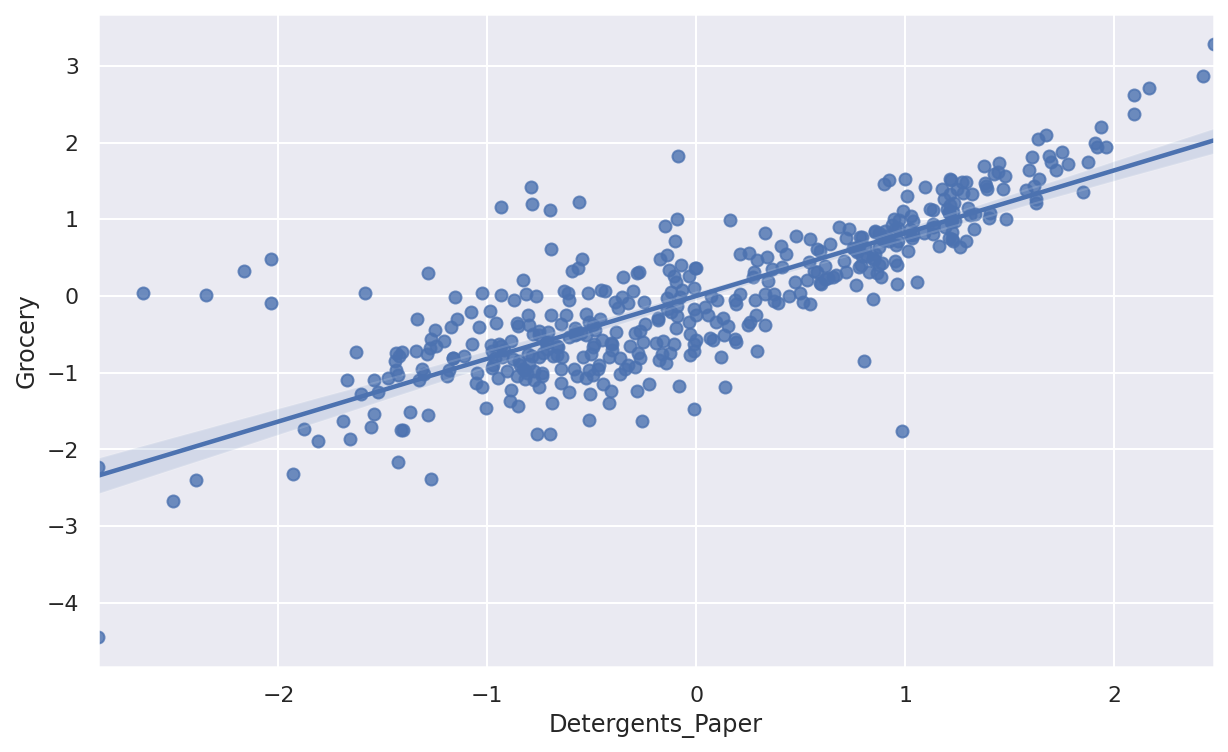

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(data=data_normal, x="Detergents_Paper",y="Grocery")
plt.show()

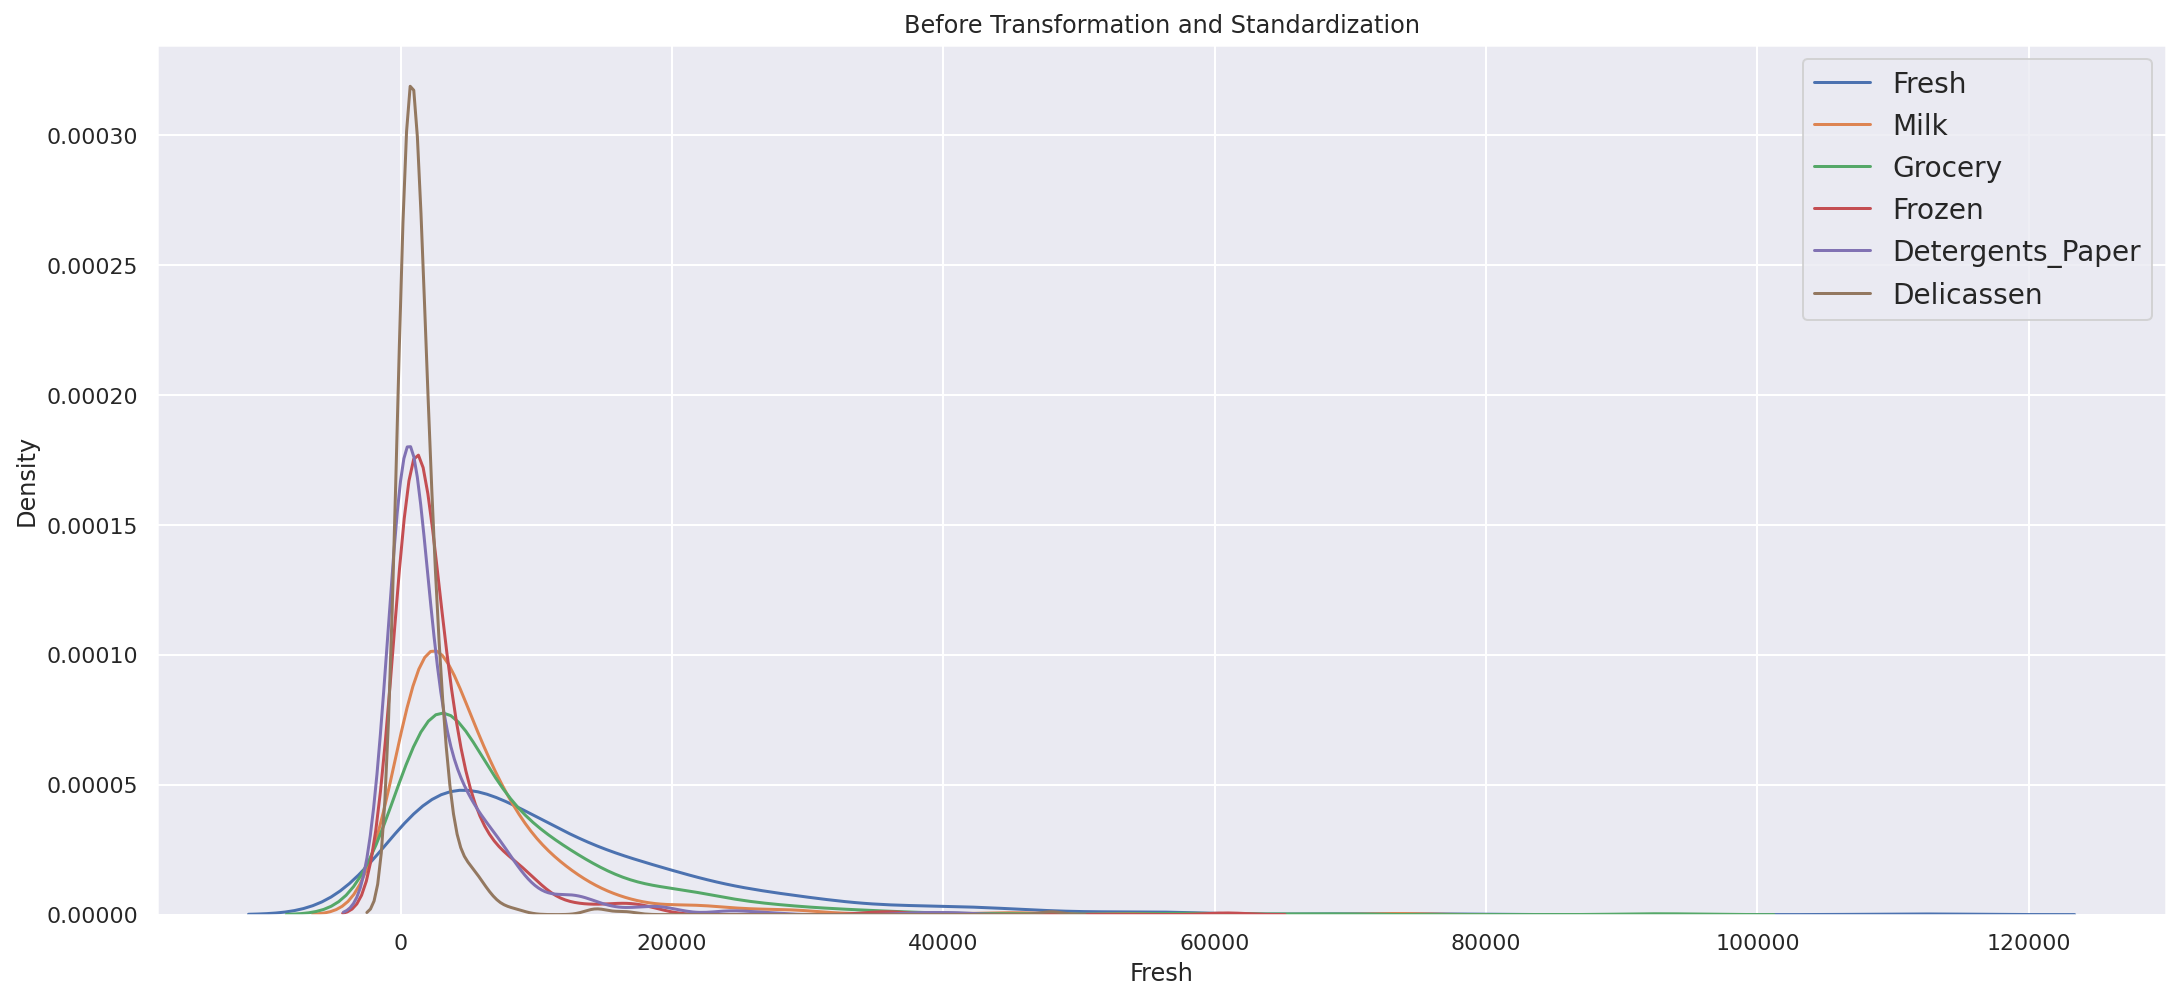

In [ ]:
plt.figure(figsize = (18,8))
plt.title('Before Transformation and Standardization')

for cols in data.columns.values:
    ax = sns.kdeplot(data[cols], Label=cols)
    ax.legend(loc=0, prop={'size': 14})

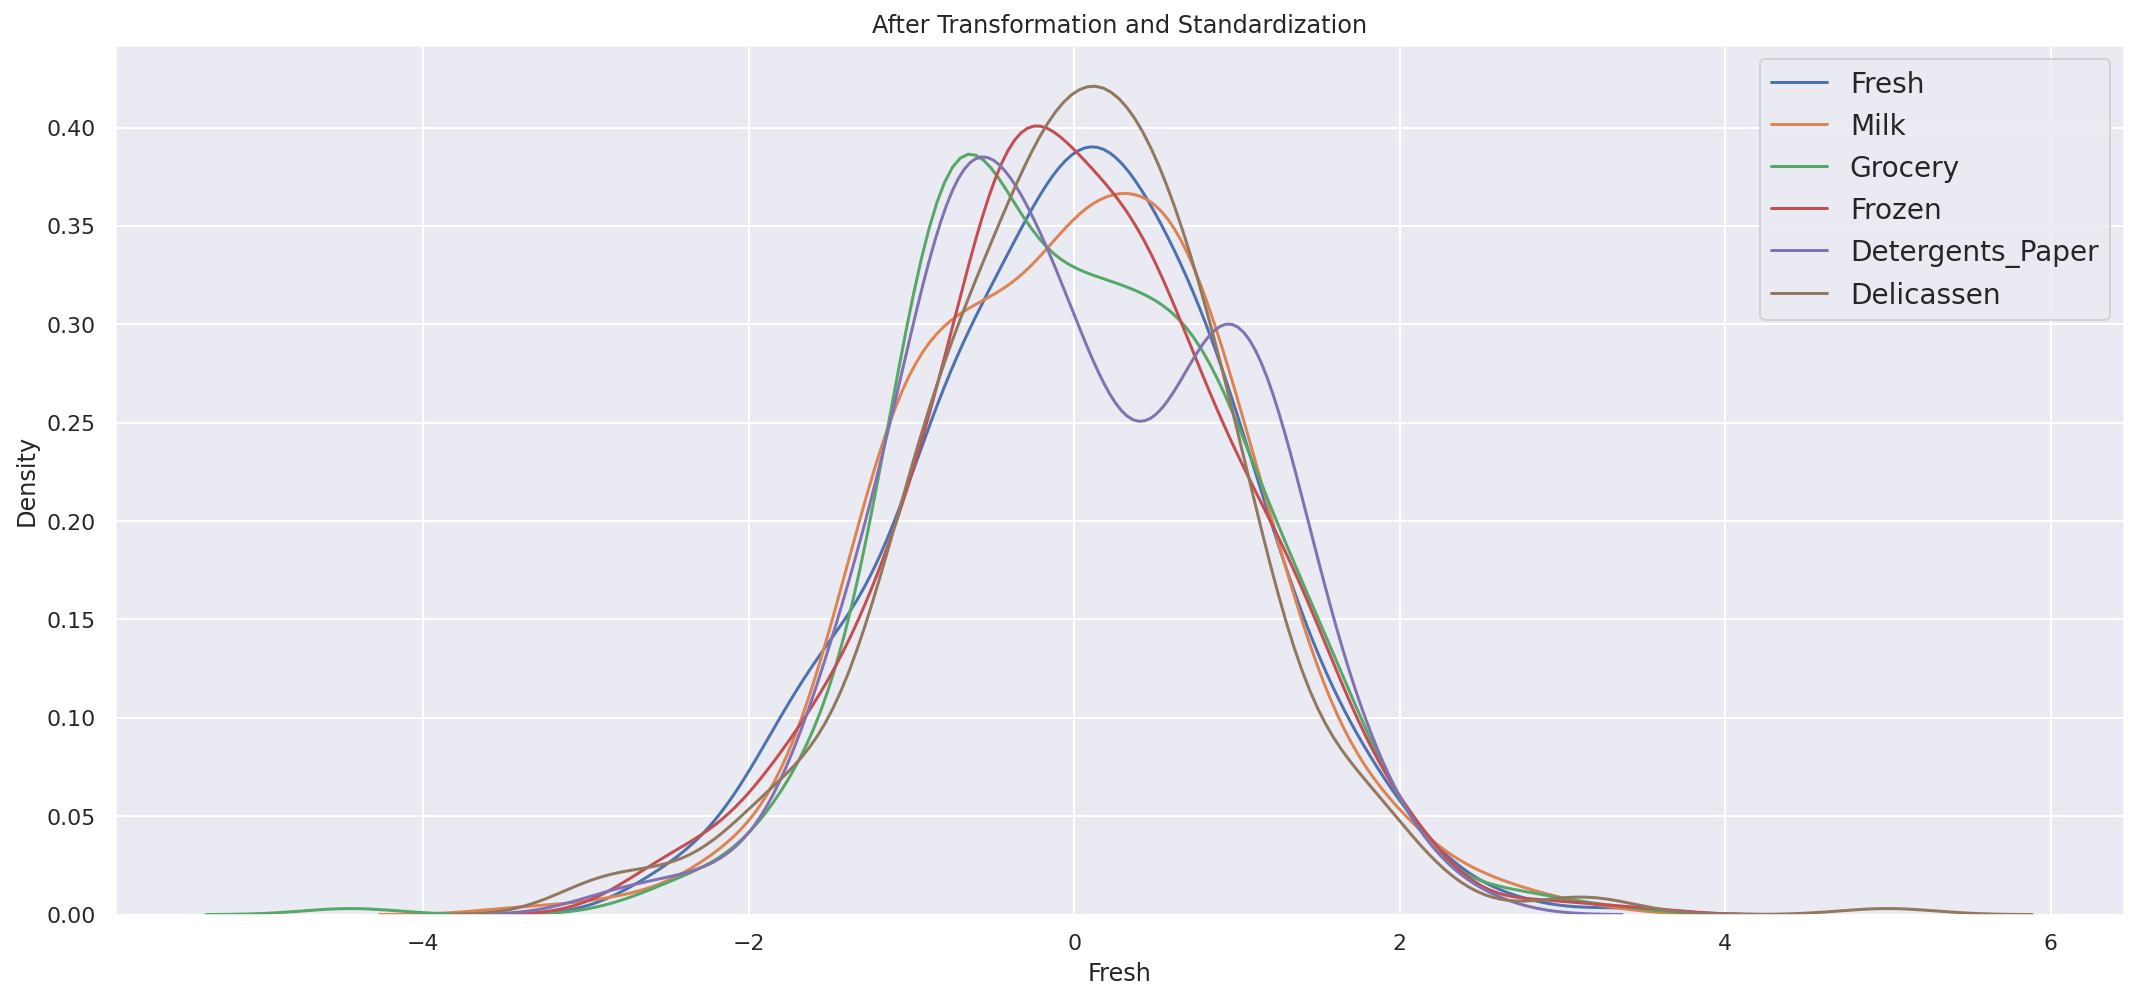

In [ ]:
plt.figure(figsize = (18,8))
plt.title('After Transformation and Standardization')

for cols in data_normal.columns.values:
    ax = sns.kdeplot(data_normal[cols], Label=cols)
    ax.legend(loc=0, prop={'size': 14})

The above graph shows the normalization of the data after transformation and standardization.

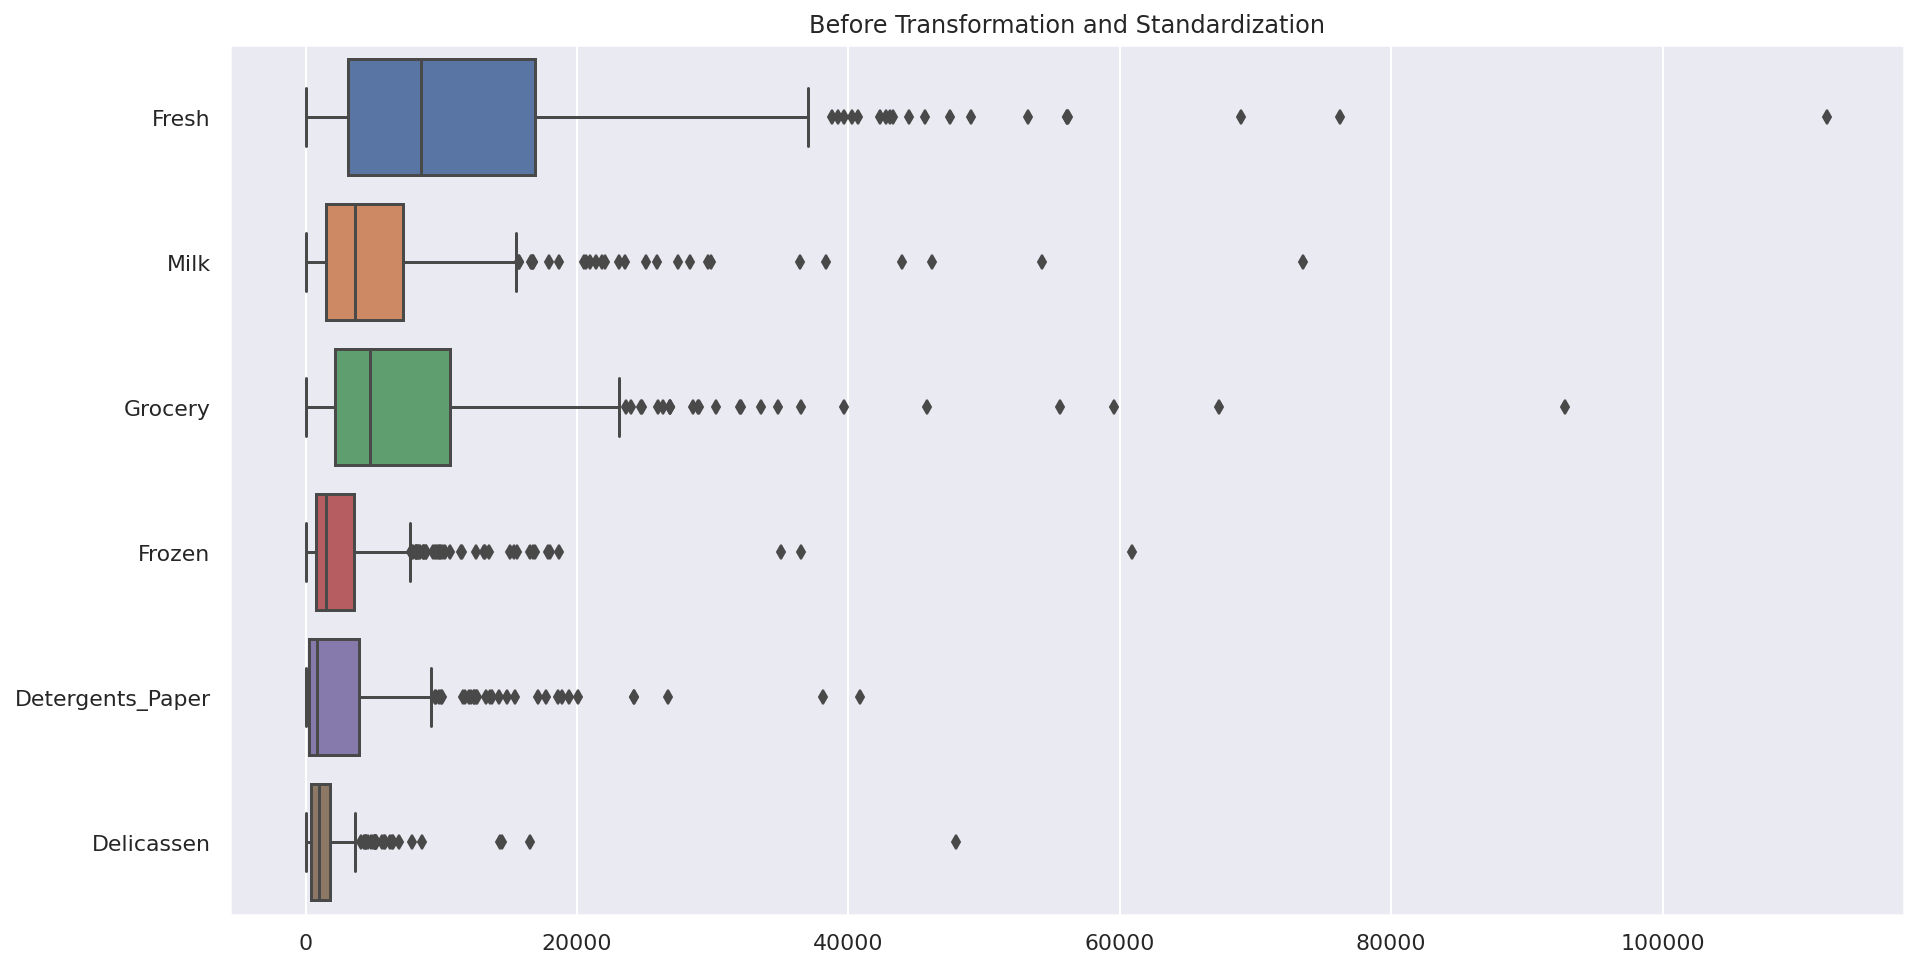

In [ ]:
plt.figure(figsize = (15,8))
sns.boxplot(data=data, orient='h')
plt.title('Before Transformation and Standardization')
plt.show()

The data before the transformation and the standardization is varied with outliers and different sized ranges.

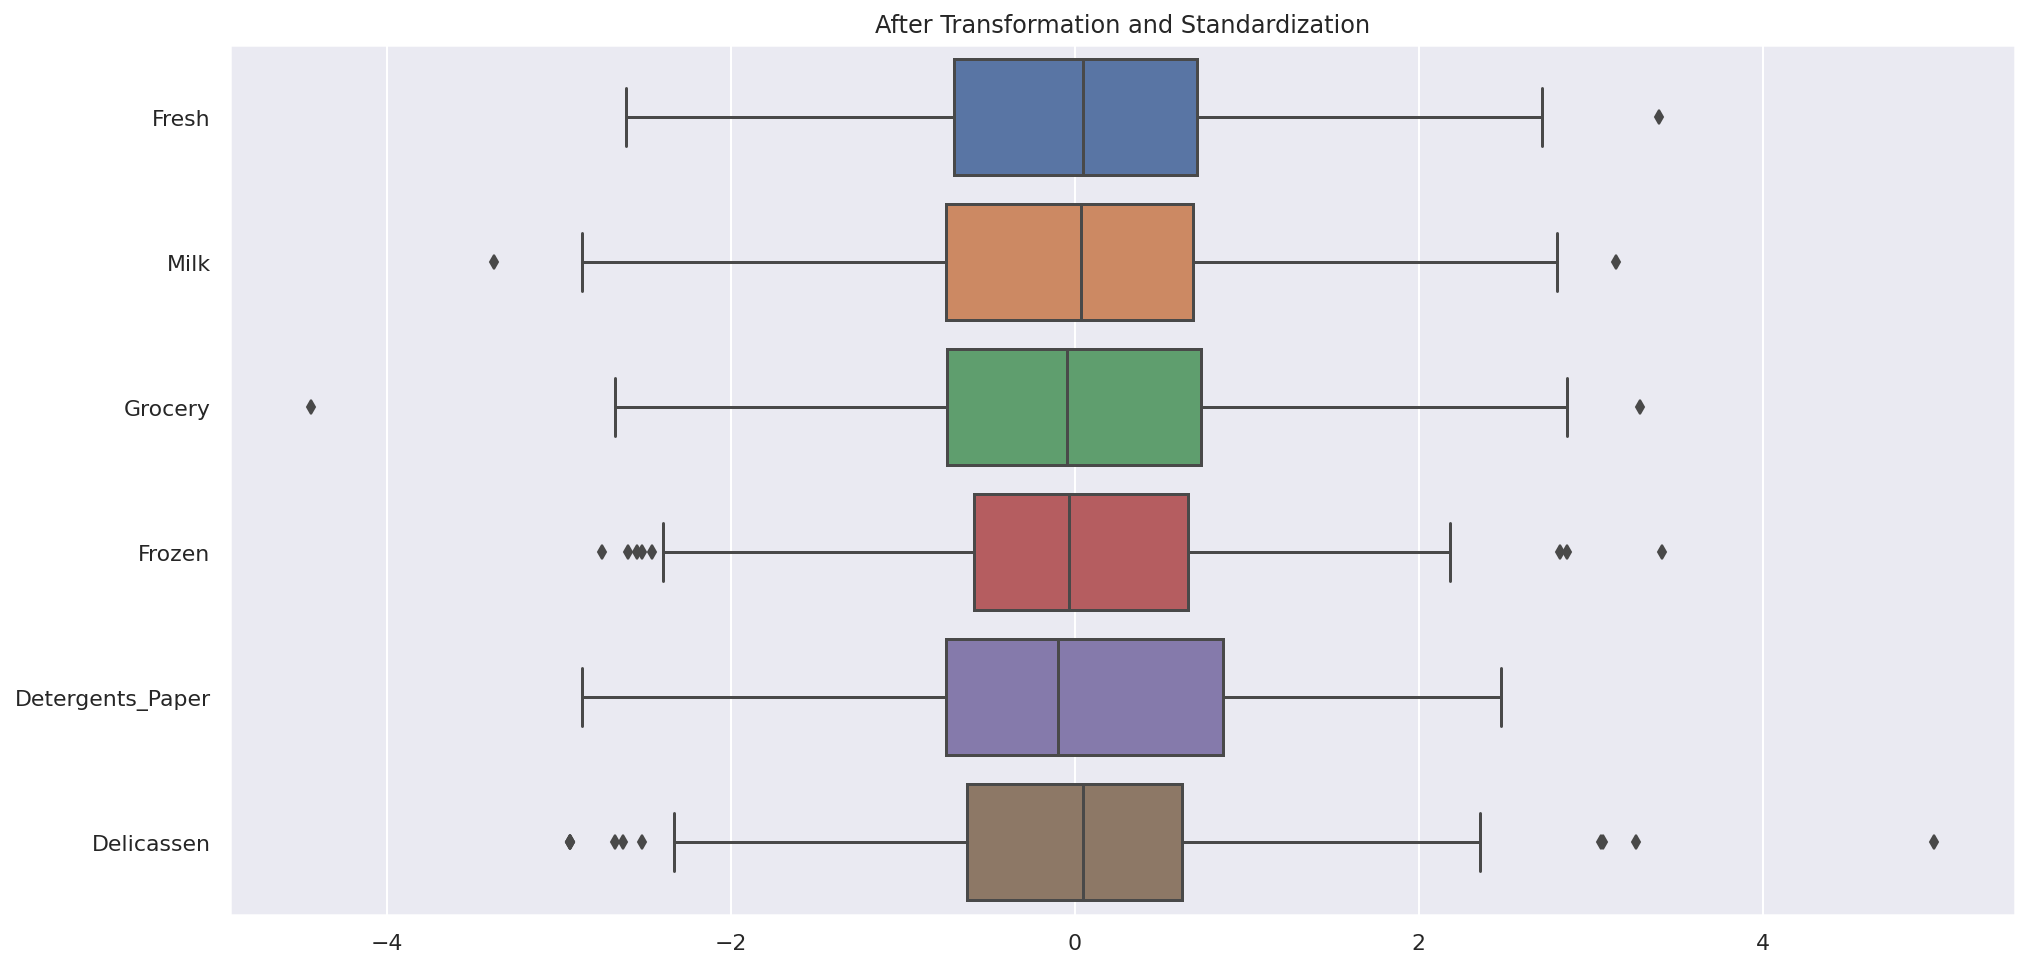

In [ ]:
plt.figure(figsize = (16,8))
sns.boxplot(data=data_normal, orient='h')
plt.title('After Transformation and Standardization')
plt.show()

The data after the transformation and the standardization was repositioned around zero with less outliers and more similar ranges. The central tendencies are also more aligned among the nominal categories.

### Run kmeans with all variables:

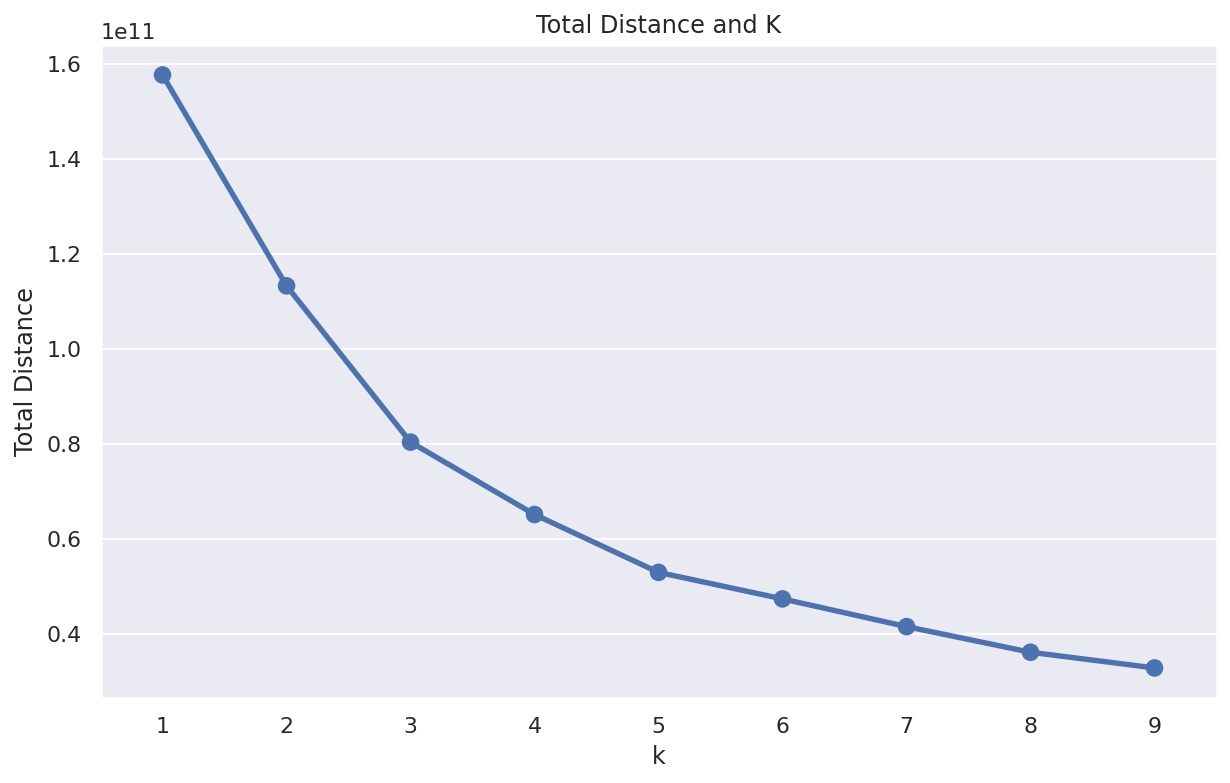

In [ ]:
# try different k values to find the elbow
dist = {}

for k in range(1,10):
    kmeans = KMeans(n_clusters = k, init='k-means++', random_state=1)
    cluster_labels = kmeans.fit_predict(data_normal)
    dist[k] = kmeans.inertia_
   
plt.figure(figsize=(10,6))
plt.xlabel('k')
plt.ylabel('Total Distance')
plt.title('Total Distance and K')
sns.pointplot(x = list(dist.keys()), y = list(dist.values()))

plt.show()

It appears that k=3 or 4 is a good choice of kvalue for our kmeans algorithm as the pivot seems to commence around those values of k.

Let's see what features are most important using PCA:

## Feature Importance Extraction with PCA

In [ ]:
# PCA without specifying number of components

pca = PCA()
while True: 
    try: 
        comp = pca.fit_transform(data_normal)
        break 
    except: 
        continue


print("How much of variance in data is explained by each each component:\n")
pca.explained_variance_ratio_

How much of variance in data is explained by each each component:



array([0.44889984, 0.28002326, 0.10189812, 0.09626769, 0.04639271,
       0.02651837])

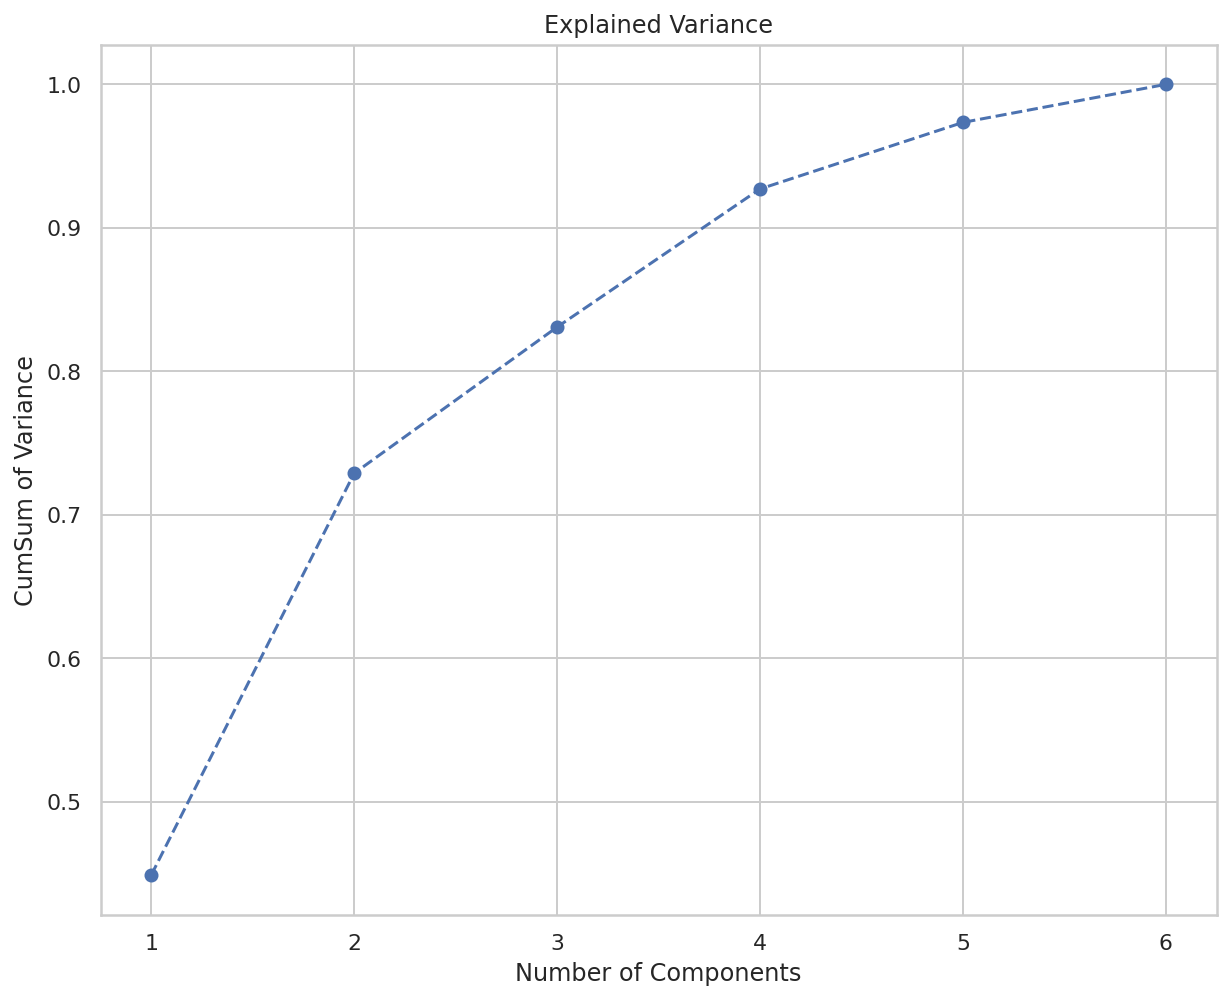

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(range(1,7), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('CumSum of Variance')
plt.show()

80% of data is explained by only 2 components. Thus, we will be using 2 components for further analysis. 

In [ ]:
# run PCA to get 2 features

pca = PCA(n_components=2)
while True: 
    try: 
        data_2f = pca.fit_transform(data_normal)
        break 
    except: 
        continue


### Run kmeans on PCA transformed data (only 2 features):

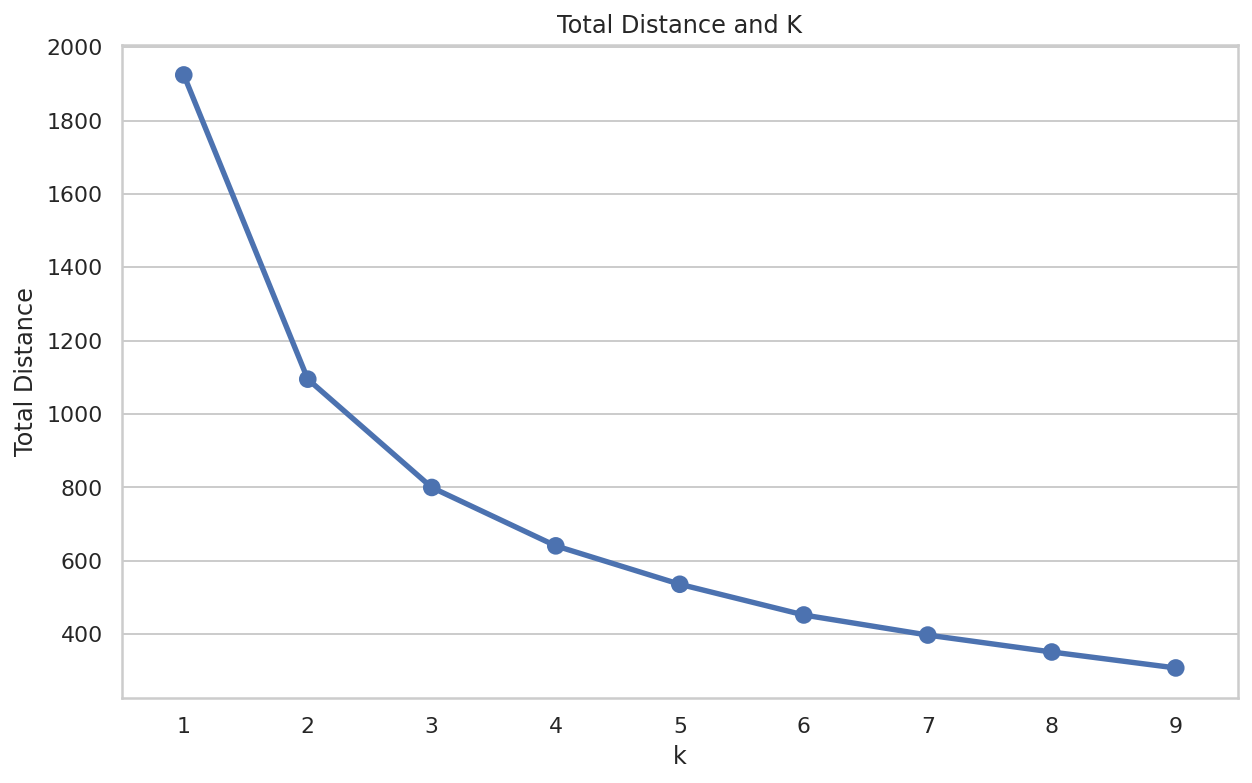

In [ ]:
# try different k values to find the elbow
dist = {}

for k in range(1,10):
    kmeans = KMeans(n_clusters = k, init='k-means++', random_state=1)
    # using data_2f (reduced data)
    cluster_labels = kmeans.fit_predict(data_2f)
    dist[k] = kmeans.inertia_
   
plt.figure(figsize=(10,6))
plt.xlabel('k')
plt.ylabel('Total Distance')
plt.title('Total Distance and K')
sns.pointplot(x = list(dist.keys()), y = list(dist.values()))

plt.show()

From the plot above, we can run kmeans with 2 and 3 clusters using the reduced data.

In [70]:
# k=2 
kmeans_2f = KMeans(n_clusters = 2, init='k-means++', max_iter = 1000, random_state = 1)
kmeans_2f.fit(data_2f)
predict = kmeans_2f.predict(data_2f)
centers = kmeans_2f.cluster_centers_

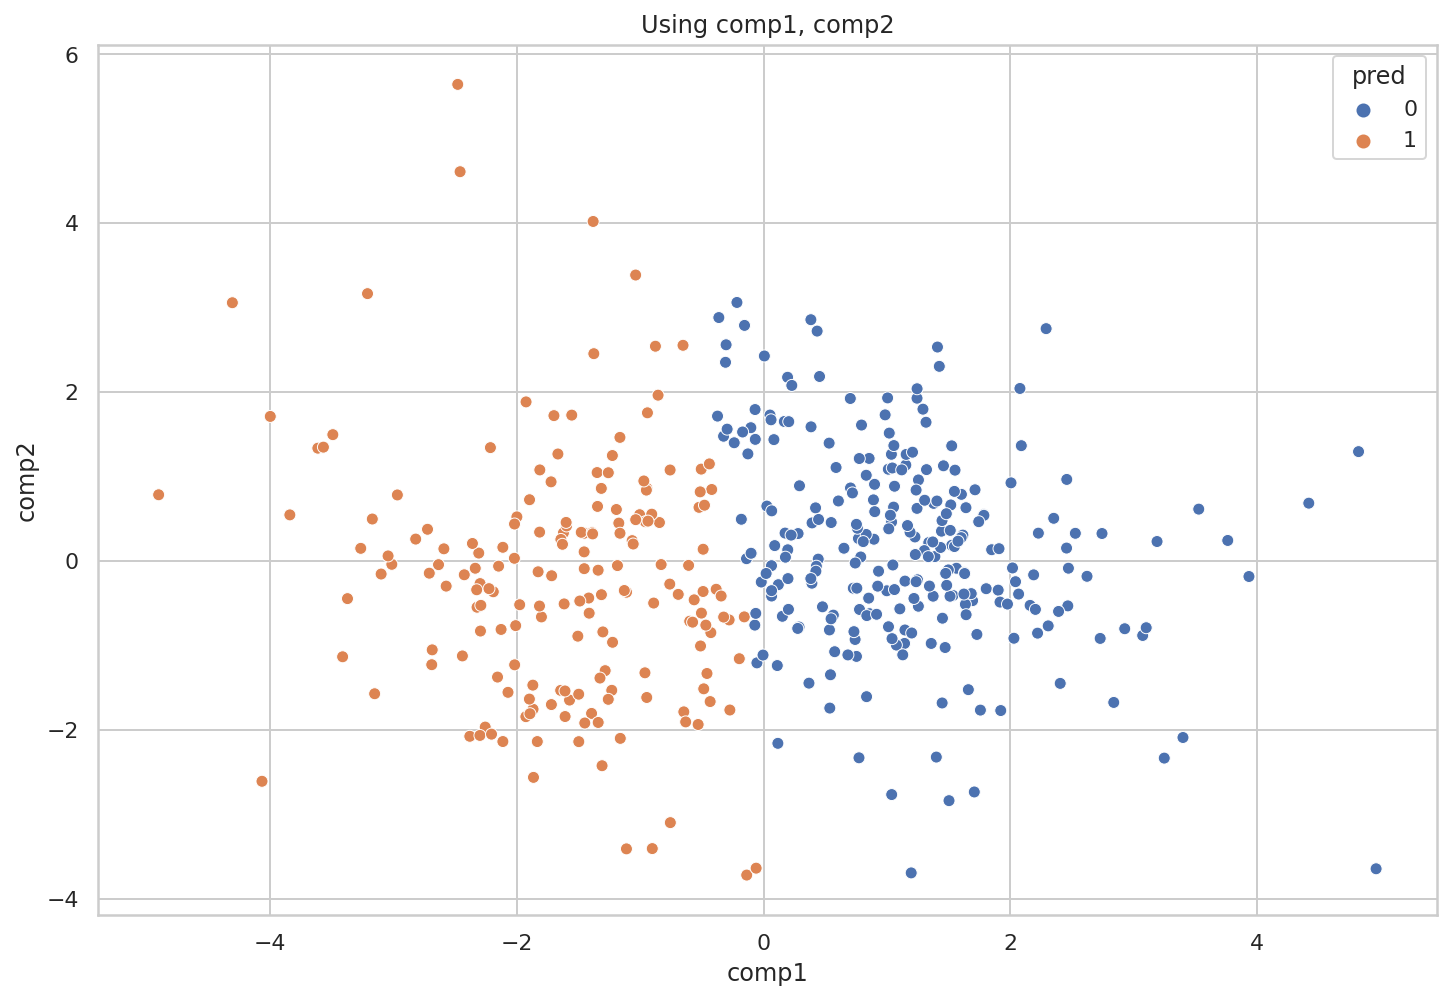

In [72]:
plt.figure(figsize = (12,8))
X = pd.DataFrame(data_2f[:, [0,1]], columns=['comp1', 'comp2'])

# we will use kmeans_2f prediction to plot the 2 clusters 
# and compare it below with "channel" label
X['pred'] = predict
sns.scatterplot('comp1', 'comp2', data=X, hue='pred', palette="deep")
plt.title('Using comp1, comp2')
plt.show()

Utilizing both component 1 and 2 for the kmeans algorithm, we get an almost medial split on the data around the 0 component 1 axis.

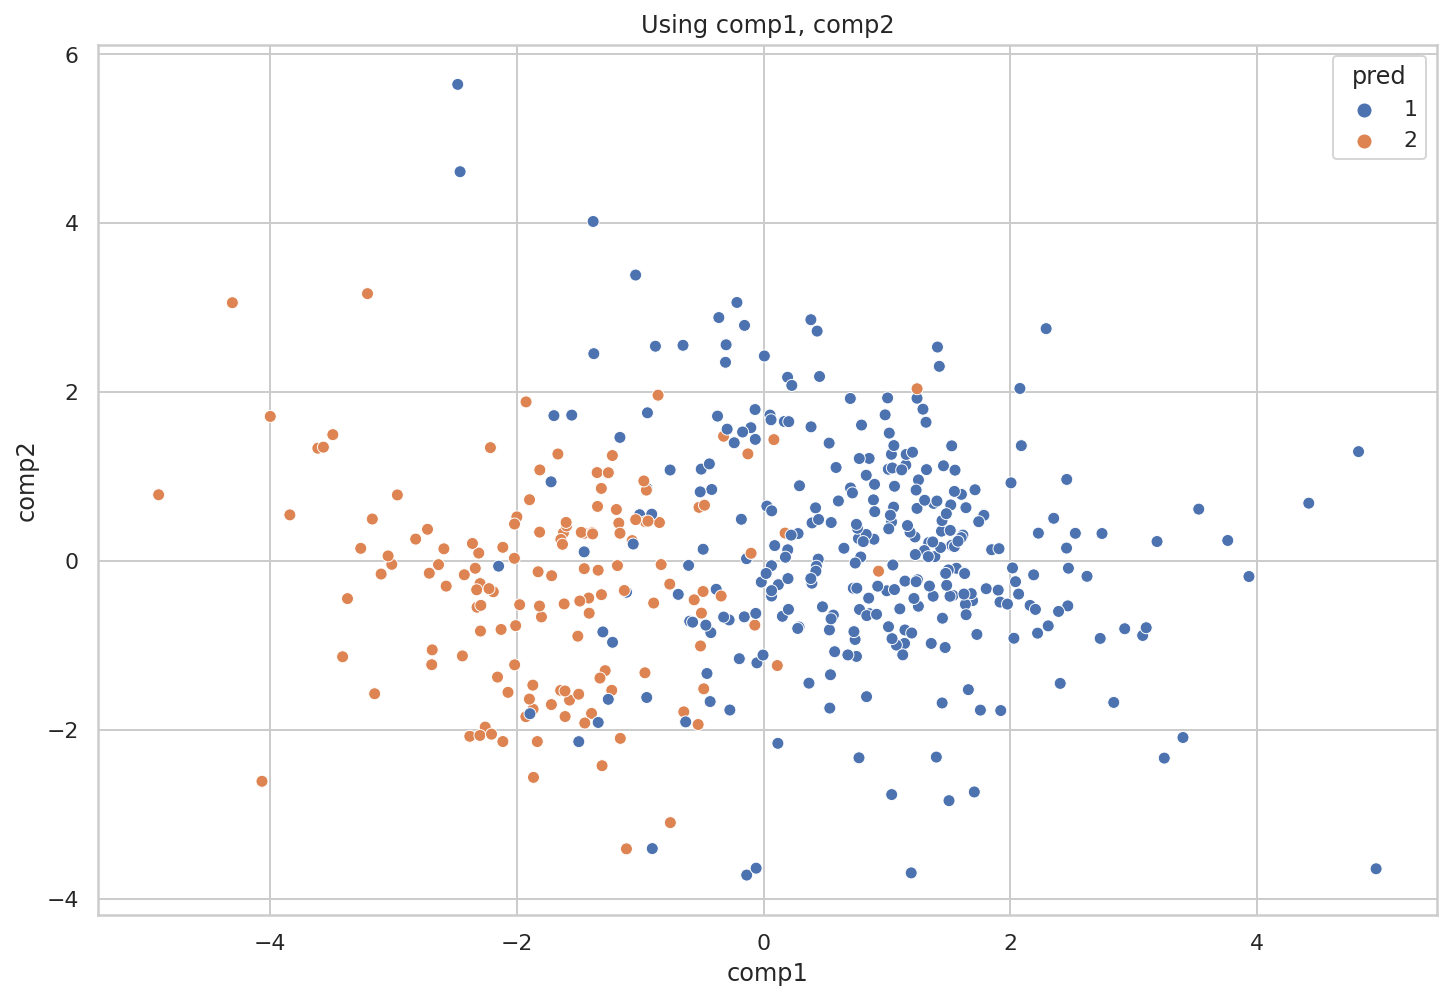

In [73]:
plt.figure(figsize = (12,8))
X = pd.DataFrame(data_2f[:, [0,1]], columns=['comp1', 'comp2'])

# using Channel column to compare plots
X['pred'] = Channel
sns.scatterplot('comp1', 'comp2', data=X, hue='pred', palette="deep")
plt.title('Using comp1, comp2')
plt.show()

The two graphs above have some similarity in how they show the 2 clusters. The second graph contains the labels grpah of the data and as we can observe, the split is not exactly on the zero value of the comp1 axis and overlapps with the 2 labels. 

Now let's try using 3 clusters on the reduced data:

In [75]:
# k=3
kmeans_2f_3c = KMeans(n_clusters = 3, init='k-means++', max_iter = 1000, random_state = 1)
kmeans_2f_3c.fit(data_2f)
predict_3c = kmeans_2f_3c.predict(data_2f)
centers_3c = kmeans_2f_3c.cluster_centers_

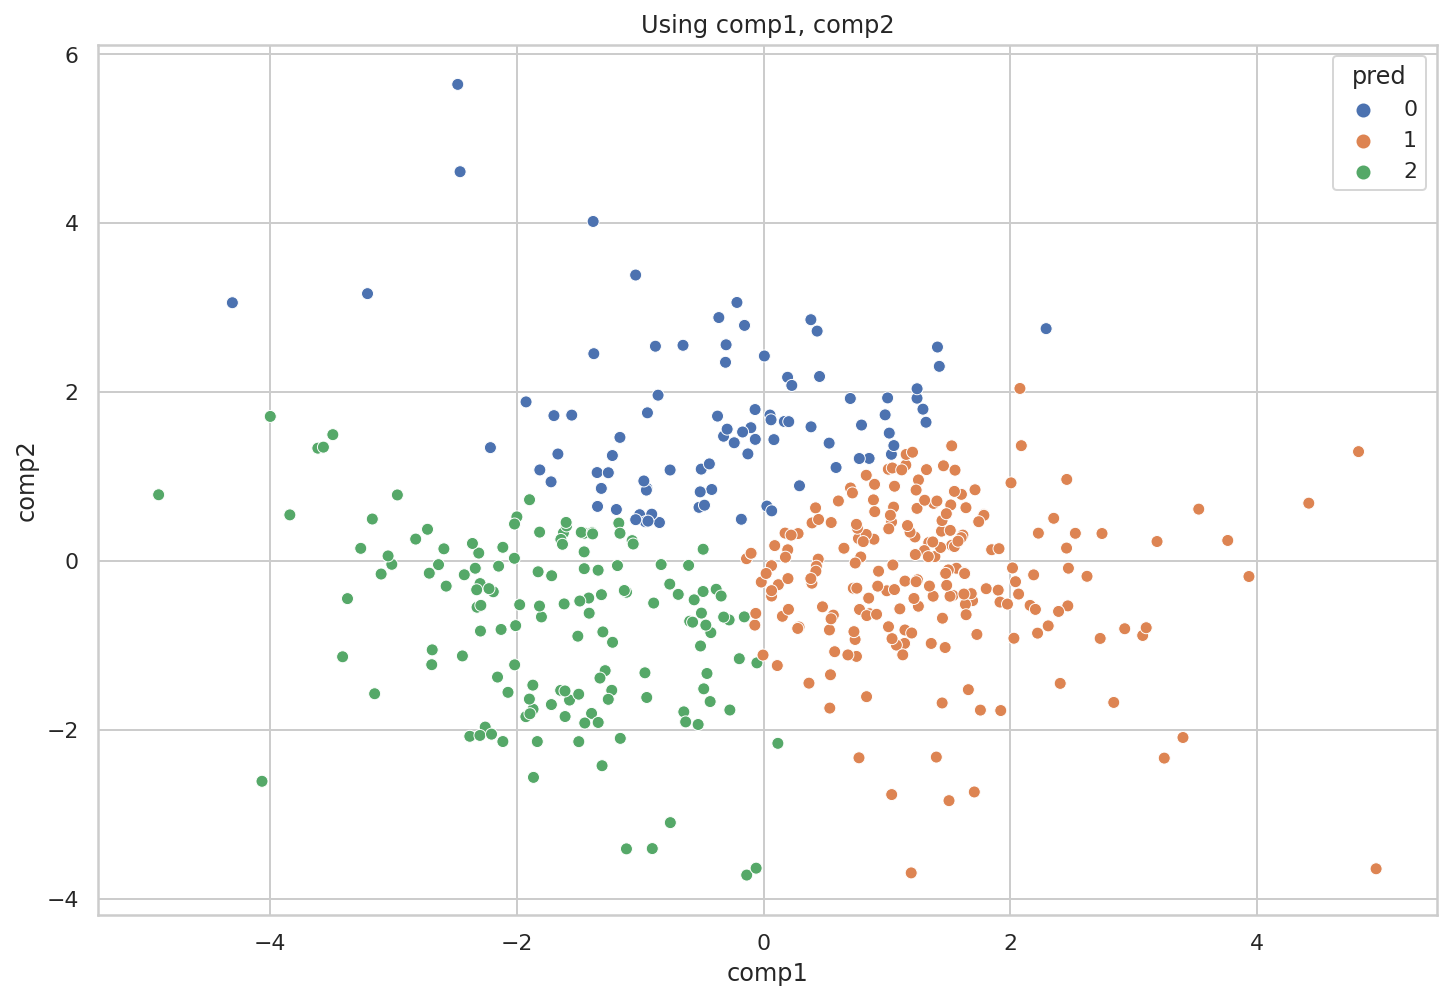

In [76]:
plt.figure(figsize = (12,8))
X = pd.DataFrame(data_2f[:, [0,1]], columns=['comp1', 'comp2'])

# we will use kmeans_2f_3c prediction to plot the 3 clusters 
# and compare it below with "region" label
X['pred'] = predict_3c
sns.scatterplot('comp1', 'comp2', data=X, hue='pred', palette="deep")
plt.title('Using comp1, comp2')
plt.show()

Using the 3 clusters gives us a triple separation that distinguishes 0,1, and 2 from each other. 

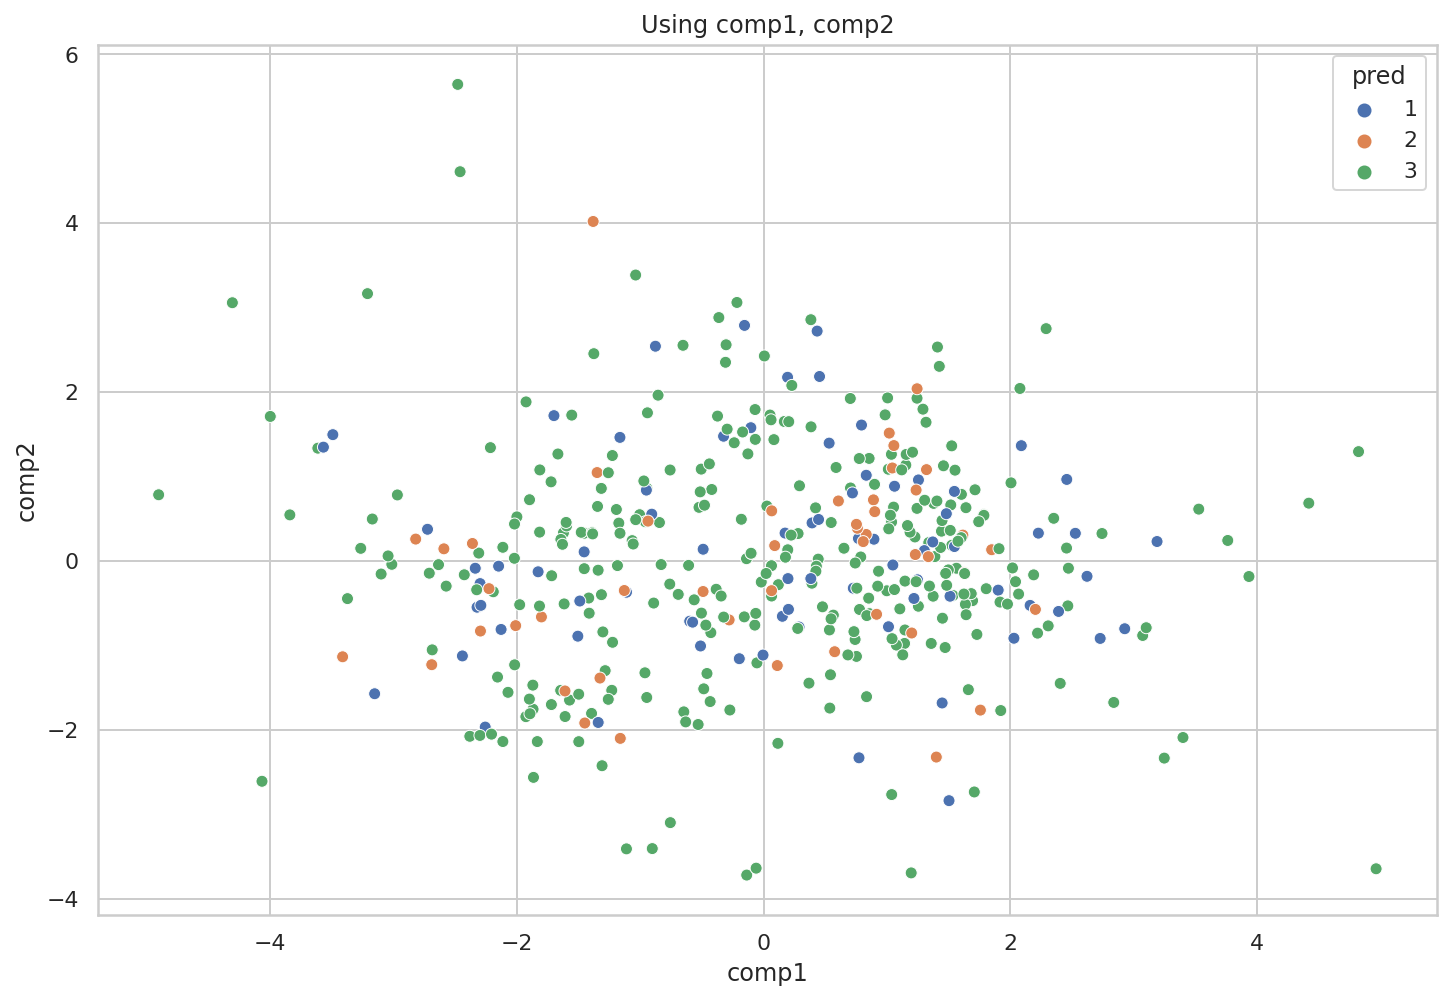

In [77]:
plt.figure(figsize = (12,8))
X = pd.DataFrame(data_2f[:, [0,1]], columns=['comp1', 'comp2'])

# using Region column to compare plots
X['pred'] = Region
sns.scatterplot('comp1', 'comp2', data=X, hue='pred', palette="deep")
plt.title('Using comp1, comp2')
plt.show()

The 2 plots above are very different in how they show 3 clusters and 3 regions. The graph above shows more of an overlap than the 3 k-means clusters.

Let's try 3 features from PCA:

## Extracting Three Features Utilizing PCA

In [78]:
# run PCA to get 2 features

pca = PCA(n_components=3)
while True: 
    try: 
        data_3f = pca.fit_transform(data_normal)
        break 
    except: 
        continue

In [82]:
# k=3
kmeans_3f_3c = KMeans(n_clusters = 3, init='k-means++', max_iter = 1000, random_state = 1)
kmeans_3f_3c.fit(data_3f)
predict_3f_3c = kmeans_3f_3c.predict(data_3f)
centers_3f_3c = kmeans_3f_3c.cluster_centers_

In [83]:
# plt.figure(figsize = (12,8))
# X = pd.DataFrame(data_3f[:, [0,1,2]], columns=['comp1', 'comp2', 'comp3'])

# # we will use kmeans_2f_3c prediction to plot the 3 clusters 
# # and compare it below with "region" label
# X['pred'] = predict_3f_3c
# sns.scatterplot('comp1', 'comp2', data=X, hue='pred', palette="deep")
# plt.title('Using comp1, comp2')
# plt.show()

first = data_3f[:, 0]
second = data_3f[:, 1]
third = data_3f[:, 2]
fig = explot.scatter_3d(x=first, y = second, z = third, color = predict_3f_3c, width=900, height=600)
fig.show()

In [84]:
# using Region column to compare plots

first = data_3f[:, 0]
second = data_3f[:, 1]
third = data_3f[:, 2]
fig = explot.scatter_3d(x=first, y = second, z = third, color = Region, width=900, height=600)
fig.show()

### Run kmeans with two variable combo:

Milk and Grocery

Milk and Frozen

Milk and Fresh

Milk and Detergents_Paper

Milk and Delicassen

Grocery and Frozen

Grocery and Fresh

Grocery and Detergents_Paper

Grocery and Delicassen

Frozen and Fresh

Frozen and Detergents_Paper

Frozen and Delicassen

Fresh and Detergents_Paper

Fresh and Delicassen

Detergents and Paper-Delicassen


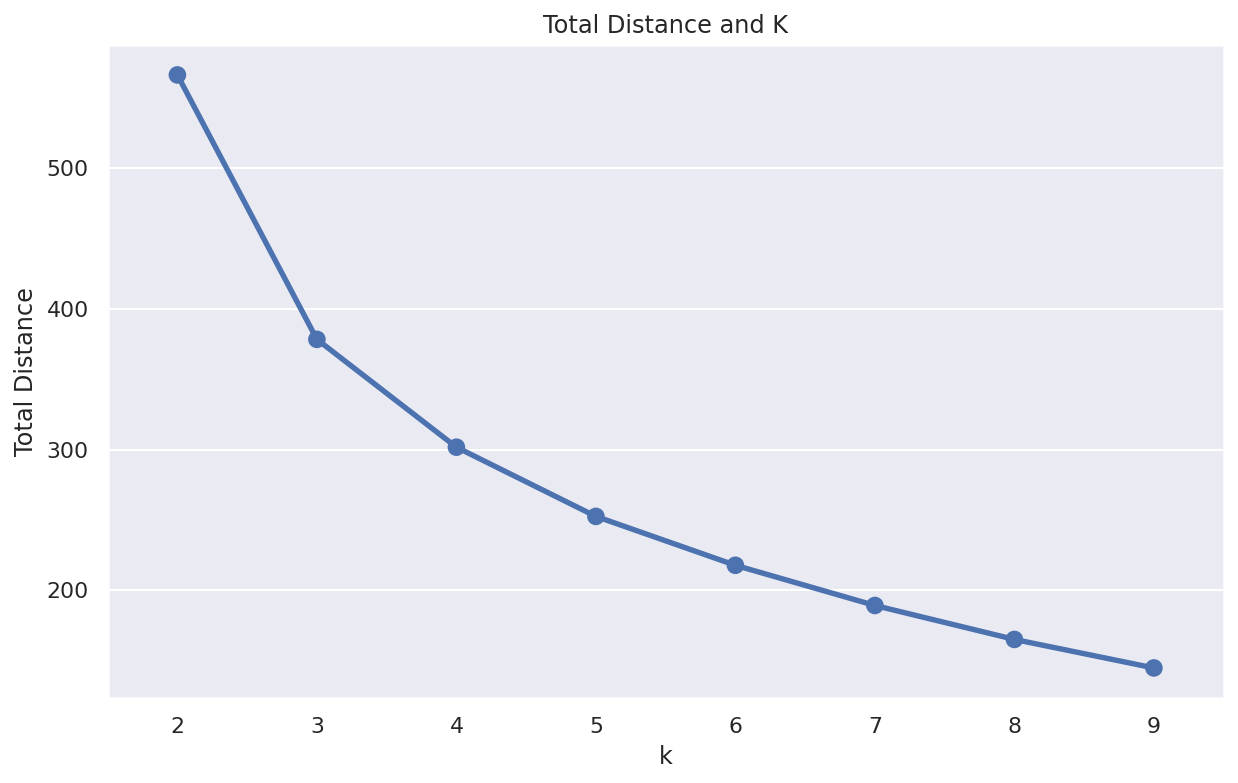

In [ ]:
# try different k values to find the elbow
# using 'Fresh' and 'Milk'

X = pd.DataFrame(data_normal.iloc[: , [0,1]].values, columns=['Fresh', 'Milk'])
dist = {}

for k in range(2,10):
    kmeans = KMeans(n_clusters = k, random_state=1)
    cluster_labels = kmeans.fit_predict(X)
    dist[k] = kmeans.inertia_
   
plt.figure(figsize=(10,6))
plt.xlabel('k')
plt.ylabel('Total Distance')
plt.title('Total Distance and K')
sns.pointplot(x = list(dist.keys()), y = list(dist.values()))

plt.show()

The above graph demonstrates the attempt to find the pivot/elbow of the curve of find the best k-value for the clusters.

In [ ]:
kmeans = KMeans(n_clusters = 3, max_iter = 1000, random_state = 1)
kmeans.fit(X)
predict = kmeans.predict(X)
centers = kmeans.cluster_centers_

In [ ]:
print(centers)

[[ 0.12103578 -0.94309151]
 [-0.92556712  0.62076327]
 [ 0.97187579  0.65210051]]


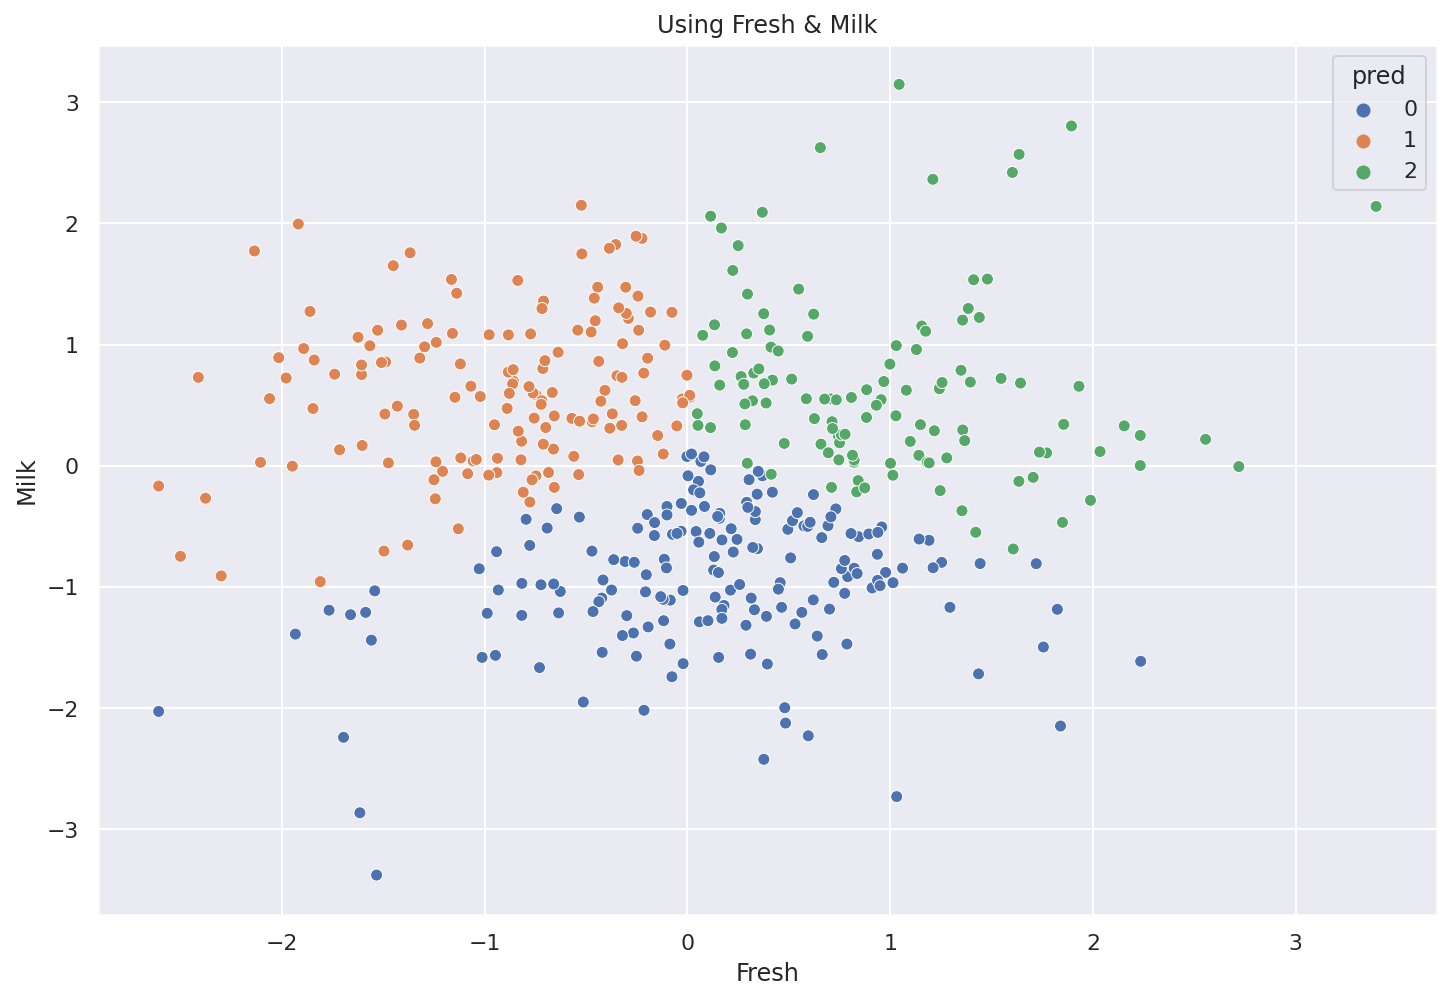

In [ ]:
plt.figure(figsize = (12,8))
X['pred'] = predict
sns.scatterplot('Fresh', 'Milk', data=X, hue='pred', palette="deep")
plt.title('Using Fresh & Milk')
plt.show()

This graph evinces the 3-divisions that the k-means cluster algorithm with 3 cluster centers. The split is evident and has a pattern to determining the labels for 0,1,and 2.

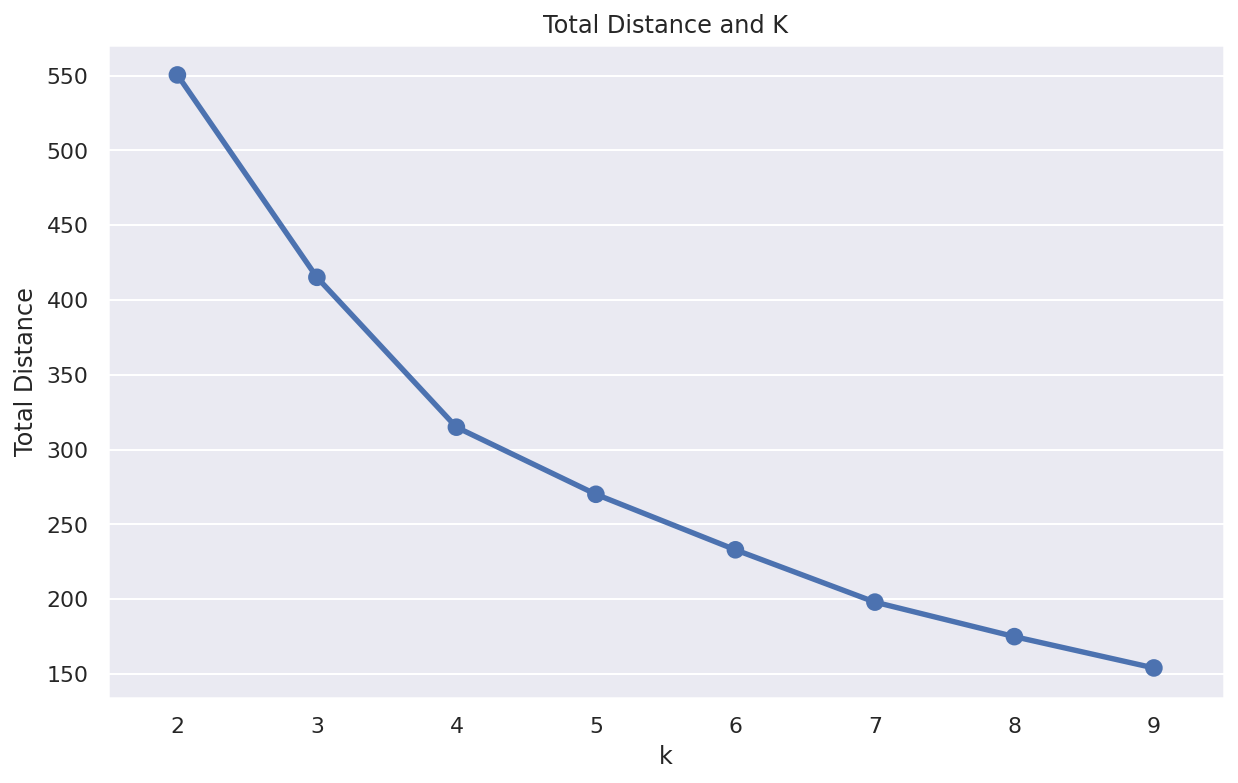

In [ ]:
# ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

X = pd.DataFrame(data_normal.iloc[: , [3,5]].values, columns=['Frozen', 'Delicassen'])
dist = {}

for k in range(2,10):
    kmeans = KMeans(n_clusters = k, random_state=1)
    cluster_labels = kmeans.fit_predict(X)
    dist[k] = kmeans.inertia_
   
plt.figure(figsize=(10,6))
plt.xlabel('k')
plt.ylabel('Total Distance')
plt.title('Total Distance and K')
sns.pointplot(x = list(dist.keys()), y = list(dist.values()))

plt.show()

The same process was replicated to determine the hinge/ number of clusters that must be used to most effectivel separate the data. As seen, the better cluster centers would arise with 4 cluster centers for the data. 

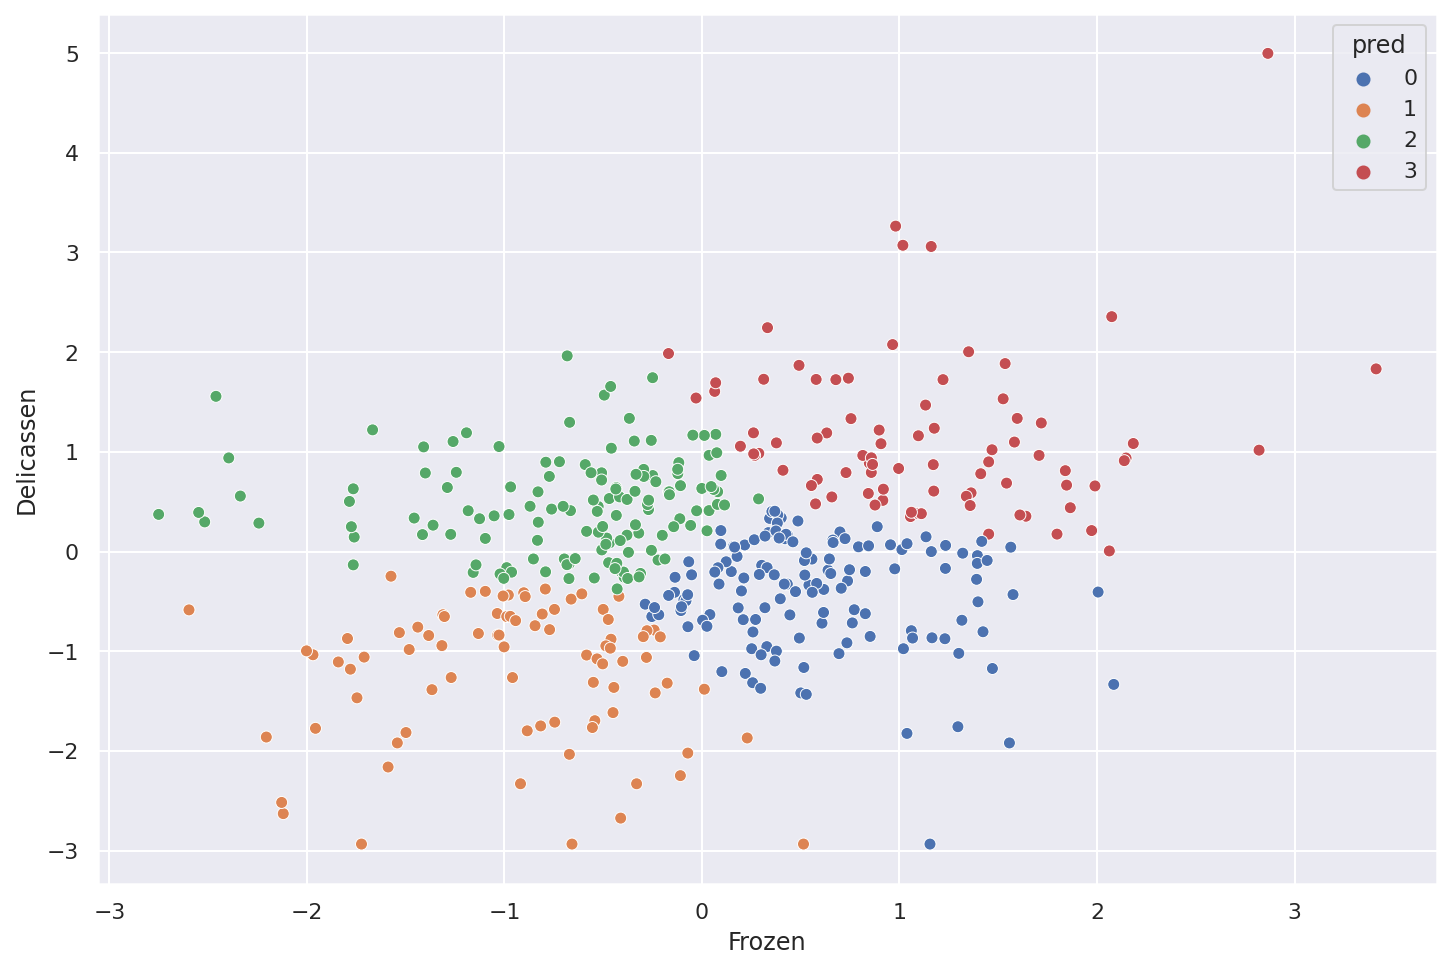

In [ ]:
kmeans = KMeans(n_clusters = 4, max_iter = 1000, random_state = 1)
kmeans.fit(X)
predict = kmeans.predict(X)
centers = kmeans.cluster_centers_

plt.figure(figsize = (12,8))
X['pred'] = predict
sns.scatterplot('Frozen', 'Delicassen', data=X, hue='pred', palette="deep")
plt.show()


The result of the 4 cluster-mean algorithm resulted in an decent separation of labels.

In [ ]:
kmeans = KMeans(n_clusters = 2, init='k-means++', max_iter = 1000, random_state = 1)
kmeans.fit(data_normal)
predict = kmeans.predict(data_normal)
centers = kmeans.cluster_centers_

In [ ]:
compare_df = pd.DataFrame(columns=['Y', 'Pred'])
compare_df['Y'] = Y
compare_df['Pred'] = predict + 1
compare_df

,Y,Pred
0,2,2
1,2,2
2,2,2
3,1,1
4,2,2
...,...,...
435,1,2
436,1,1
437,2,2
438,1,1


In [ ]:
score = metrics.accuracy_score(Y, predict+1)
print('Accuracy:{0:f}'.format(score))

Accuracy:0.865909


# Results of Accuracy:

The accuracy score has a relatively good score, correctly labelling 86.59% of the data when the labels were excluded and k-means was utilized as the primary method for classification/clustering. The algorithm mostly correctly and farily extrapolated the groups that each datapoint was directly correlated with. After normalizing the data and applying PCA to extract the important components/features to cluster over, we have achieved a farily accurate model that differentiated the business that each wholesale client belonged to.